## Stappenplan:
1. Data transformation
- Pivot; clean; remaining features:
      ['Datum', 'Binnengekomen bij Provider', 'Doorgeleid naar keuzemenu',
       'Door beller opgehangen in menu', 'Automatisch behandeld in menu',
       'Doorverbindingen_totaal',  'Wachtrij_totaal', 'Wachtrij_opgehangen_totaal',
       'Geholpen_totaal', 'Gemiddelde_wachttijd_totaal', & per cat:
       'Doorverbindingen_CAT', 
       'Wachtrij_CAT',
       'Wachtrij_opgehangen_CAT',
       'Geholpen_CAT', 
       'Gemiddelde_wachttijd_CAT']
     
2. Data enrichment
- Calender events/holidays/tax deadlines
- Weather

3. Model

In [1]:
pip install workalendar

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import seaborn as sns
from cycler import cycler
from workalendar.europe import Netherlands
import json
from datetime import date, timedelta
from datetime import datetime 
import calendar

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

line_cycler   = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["-", "--", "-.", ":", "-", "--", "-."]))

## 1. Data transformation

### Data inladen; kolom 'Datum' in data format zetten

In [3]:
data = pd.read_csv('belastingtelefoon_odt003 (3).csv', sep = ';', decimal = ",") # douane eruit

In [4]:
data['Datum'] = pd.to_datetime(data['Datum'], format =  "%d/%m/%Y")

### Kolommen hernoemen; null-waardes vervangen door 0

In [5]:
data = data.fillna(0) 

In [6]:
data.columns = ['Datum', 'Binnengekomen bij Provider', 'Doorgeleid naar keuzemenu',
       'Door beller opgehangen in menu', 'Automatisch behandeld in menu',
       'Thema', 'Doorverbindingen', 'Wachtrij',
       'Wachtrij_opgehangen', 'Geholpen',
       'Gemiddelde_wachttijd','','']
data=data[['Datum', 'Binnengekomen bij Provider', 'Doorgeleid naar keuzemenu',
       'Door beller opgehangen in menu', 'Automatisch behandeld in menu',
       'Thema', 'Doorverbindingen', 'Wachtrij',
       'Wachtrij_opgehangen', 'Geholpen',
       'Gemiddelde_wachttijd']]

In [7]:
df_dagelijkse_totaal = data[data['Thema'] == 'TOTAAL'][['Datum', 'Binnengekomen bij Provider', 'Doorgeleid naar keuzemenu',
       'Door beller opgehangen in menu', 'Automatisch behandeld in menu']]

### Pivot de thema kolommen en join deze df met de totals dataframe

In [8]:
df_dagelijkse_themas = data.pivot(index='Datum', columns='Thema', values=['Doorverbindingen', 'Wachtrij',
       'Wachtrij_opgehangen', 'Geholpen',
       'Gemiddelde_wachttijd'])

In [9]:
df_totaal = df_dagelijkse_totaal.join(df_dagelijkse_themas, on = 'Datum', how = 'inner')

In [13]:
df_totaal.columns

Index([                                  'Datum',
                    'Binnengekomen bij Provider',
                     'Doorgeleid naar keuzemenu',
                'Door beller opgehangen in menu',
                 'Automatisch behandeld in menu',
                    ('Doorverbindingen', 'AUTO'),
              ('Doorverbindingen', 'BUITENLAND'),
                  ('Doorverbindingen', 'DOUANE'),
           ('Doorverbindingen', 'INTERMEDIAIRS'),
           ('Doorverbindingen', 'ONDERNEMINGEN'),
               ('Doorverbindingen', 'ONTBREEKT'),
                  ('Doorverbindingen', 'OVERIG'),
           ('Doorverbindingen', 'PARTICULIEREN'),
               ('Doorverbindingen', 'TOESLAGEN'),
                  ('Doorverbindingen', 'TOTAAL'),
                            ('Wachtrij', 'AUTO'),
                      ('Wachtrij', 'BUITENLAND'),
                          ('Wachtrij', 'DOUANE'),
                   ('Wachtrij', 'INTERMEDIAIRS'),
                   ('Wachtrij', 'ONDERNEMINGEN'),


### Trek de douane kolommen af van het totaal (aangezien douane enkel een thema was tot februari 2020). Ga vervolgens verder met de resterende kolommen. 

In [10]:
df_totaal = df_totaal.fillna(0)
df_totaal['Binnengekomen bij Provider'] = df_totaal['Binnengekomen bij Provider'] - df_totaal[('Doorverbindingen', 'DOUANE')]
df_totaal['Doorgeleid naar keuzemenu'] = df_totaal['Doorgeleid naar keuzemenu'] - df_totaal[('Doorverbindingen', 'DOUANE')]
df_totaal[('Doorverbindingen', 'TOTAAL')] = df_totaal[('Doorverbindingen', 'TOTAAL')] - df_totaal[('Doorverbindingen', 'DOUANE')]
df_totaal[('Wachtrij', 'TOTAAL')] = df_totaal[('Wachtrij', 'TOTAAL')] - df_totaal[('Wachtrij', 'DOUANE')]
df_totaal[('Wachtrij_opgehangen', 'TOTAAL')] = df_totaal[('Wachtrij_opgehangen', 'TOTAAL')] - df_totaal[('Wachtrij_opgehangen', 'DOUANE')]
df_totaal[('Geholpen', 'TOTAAL')] = df_totaal[('Geholpen', 'TOTAAL')] - df_totaal[('Geholpen', 'DOUANE')]

### Trek de ontbrekende kolommen af van het totaal (aangezien we geen informatie hebben over de beller, kunnen we hier niets mee). Dit zijn 13 rijen. 

In [11]:
df_totaal['Wachtrij', 'ONTBREEKT'][df_totaal[('Wachtrij', 'ONTBREEKT')].notna()]

0       0.0
9       0.0
18      0.0
27      0.0
36      0.0
       ... 
7664    0.0
7672    0.0
7680    0.0
7688    0.0
7696    0.0
Name: (Wachtrij, ONTBREEKT), Length: 928, dtype: float64

In [12]:
df_totaal['Binnengekomen bij Provider'] = df_totaal['Binnengekomen bij Provider'] - df_totaal[('Doorverbindingen', 'ONTBREEKT')]
df_totaal['Doorgeleid naar keuzemenu'] = df_totaal['Doorgeleid naar keuzemenu'] - df_totaal[('Doorverbindingen', 'ONTBREEKT')]
df_totaal[('Doorverbindingen', 'TOTAAL')] = df_totaal[('Doorverbindingen', 'TOTAAL')] - df_totaal[('Doorverbindingen', 'ONTBREEKT')]
df_totaal[('Wachtrij', 'TOTAAL')] = df_totaal[('Wachtrij', 'TOTAAL')] - df_totaal[('Wachtrij', 'ONTBREEKT')]
df_totaal[('Wachtrij_opgehangen', 'TOTAAL')] = df_totaal[('Wachtrij_opgehangen', 'TOTAAL')] - df_totaal[('Wachtrij_opgehangen', 'ONTBREEKT')]
df_totaal[('Geholpen', 'TOTAAL')] = df_totaal[('Geholpen', 'TOTAAL')] - df_totaal[('Geholpen', 'ONTBREEKT')]

### Op 2022-09-14 zijn er geen oproepen geregistreerd. Het is mij onbekend of dit komt door een interne storing bij de belastingdienst, maar het lijkt erop dat die dag wel oproepen zijn binnengekomen, doorgeleid en afgewerkt, aangezien online geen informatie te vinden valt. Logischerwijs moet deze datum uit de data worden verwijderd. 

In [13]:
df_totaal = df_totaal.drop(axis=0, index = df_totaal[df_totaal['Datum'] == '2022-09-14'].index)

In [14]:

df_totaal = df_totaal[['Datum',
                    'Binnengekomen bij Provider',
                     'Doorgeleid naar keuzemenu',
                'Door beller opgehangen in menu',
                 'Automatisch behandeld in menu',
                    ('Doorverbindingen', 'AUTO'),
              ('Doorverbindingen', 'BUITENLAND'),
                  ('Doorverbindingen', 'DOUANE'),
           ('Doorverbindingen', 'INTERMEDIAIRS'),
           ('Doorverbindingen', 'ONDERNEMINGEN'),
               ('Doorverbindingen', 'ONTBREEKT'),
                  ('Doorverbindingen', 'OVERIG'),
           ('Doorverbindingen', 'PARTICULIEREN'),
               ('Doorverbindingen', 'TOESLAGEN'),
                  ('Doorverbindingen', 'TOTAAL'),
                            ('Wachtrij', 'AUTO'),
                      ('Wachtrij', 'BUITENLAND'),
                   ('Wachtrij', 'INTERMEDIAIRS'),
                   ('Wachtrij', 'ONDERNEMINGEN'),
                       ('Wachtrij', 'ONTBREEKT'),
                          ('Wachtrij', 'OVERIG'),
                   ('Wachtrij', 'PARTICULIEREN'),
                       ('Wachtrij', 'TOESLAGEN'),
                          ('Wachtrij', 'TOTAAL'),
                 ('Wachtrij_opgehangen', 'AUTO'),
           ('Wachtrij_opgehangen', 'BUITENLAND'),
        ('Wachtrij_opgehangen', 'INTERMEDIAIRS'),
        ('Wachtrij_opgehangen', 'ONDERNEMINGEN'),
            ('Wachtrij_opgehangen', 'ONTBREEKT'),
               ('Wachtrij_opgehangen', 'OVERIG'),
        ('Wachtrij_opgehangen', 'PARTICULIEREN'),
            ('Wachtrij_opgehangen', 'TOESLAGEN'),
               ('Wachtrij_opgehangen', 'TOTAAL'),
                            ('Geholpen', 'AUTO'),
                      ('Geholpen', 'BUITENLAND'),
                   ('Geholpen', 'INTERMEDIAIRS'),
                   ('Geholpen', 'ONDERNEMINGEN'),
                       ('Geholpen', 'ONTBREEKT'),
                          ('Geholpen', 'OVERIG'),
                   ('Geholpen', 'PARTICULIEREN'),
                       ('Geholpen', 'TOESLAGEN'),
                          ('Geholpen', 'TOTAAL'),
                ('Gemiddelde_wachttijd', 'AUTO'),
          ('Gemiddelde_wachttijd', 'BUITENLAND'),
       ('Gemiddelde_wachttijd', 'INTERMEDIAIRS'),
       ('Gemiddelde_wachttijd', 'ONDERNEMINGEN'),
           ('Gemiddelde_wachttijd', 'ONTBREEKT'),
              ('Gemiddelde_wachttijd', 'OVERIG'),
       ('Gemiddelde_wachttijd', 'PARTICULIEREN'),
           ('Gemiddelde_wachttijd', 'TOESLAGEN'),
              ('Gemiddelde_wachttijd', 'TOTAAL')]]

# Maand en jaar kolommen toevoegen
df_totaal['Maand'] = df_totaal['Datum'].dt.strftime('%b')
df_totaal['Jaar'] = df_totaal['Datum'].dt.strftime('%Y')

# Complexiteitsscores toevoegen
df_totaal['ComplexityScore_ondernemingen'] = 1
df_totaal['ComplexityScore_particulieren'] = 2
df_totaal['ComplexityScore_buitenland'] = 3
df_totaal['ComplexityScore_overig'] = 4
df_totaal['ComplexityScore_intermediairs'] = 5
df_totaal['ComplexityScore_toeslagen'] = 6
df_totaal['ComplexityScore_auto'] = 7

df_totaal['DagvdWeek'] = df_totaal['Datum'].dt.dayofweek
df_totaal['Maand'] = df_totaal['Datum'].dt.month
df_totaal['Dag'] = df_totaal['Datum'].dt.day
df_totaal['WeekNr'] = df_totaal['Datum'].dt.isocalendar().week

/opt/conda/lib/python3.9/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


In [15]:
df_totaal = df_totaal.reset_index(drop = True)

## 2. Data enrichment

1. Kalender events: vakanties/aangifte deadlines/uitbetaaldata
2. Weerdata

#### 1. Kalender event
- Uitbetaaldata toeslagen en voorlopige aanslagen
- Prinsjesdag
- Vakanties
- Aangifte deadlines

##### Uitbetaaldata

In [16]:
# Toeslagen en kindgebonden budget: 20e van elke maand (mits werkdag)
# bron: https://www.belastingdienst.nl/wps/wcm/connect/nl/home/content/wanneer-krijg-ik-mijn-toeslag
df_uitbetalingsdata_toeslagen = pd.DataFrame(columns=['uitbetalingsdatum'])

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

start_date = date(2019, 1, 1)
end_date = date(2023, 1, 1)

for single_date in daterange(start_date, end_date):
    if single_date.day == 20:
        if calendar.day_name[single_date.weekday()] == "Sunday":
            df_uitbetalingsdata_toeslagen = df_uitbetalingsdata_toeslagen.append({'uitbetalingsdatum' : single_date + timedelta(days=1)},ignore_index=True)
        elif calendar.day_name[single_date.weekday()] == "Saturday":
            df_uitbetalingsdata_toeslagen = df_uitbetalingsdata_toeslagen.append({'uitbetalingsdatum' : single_date + timedelta(days=2)},ignore_index=True)
        else:
            df_uitbetalingsdata_toeslagen = df_uitbetalingsdata_toeslagen.append({'uitbetalingsdatum' : single_date},ignore_index=True)
df_uitbetalingsdata_toeslagen['uitbetalingsdatum'] = df_uitbetalingsdata_toeslagen['uitbetalingsdatum'].apply(pd.to_datetime)#.apply(lambda x:x.split(' ')[0])

In [17]:
# Voorlopige aanslagen: 15e van elke maand (mits werkdag)
# bron: https://www.belastingdienst.nl/wps/wcm/connect/nl/voorlopige-aanslag/content/voorlopige-aanslag-aangevraagd-hoe-en-wanneer-krijg-ik-mijn-geld#:~:text=De%201e%20betaling%20krijgt%20u,geld%20de%201e%20werkdag%20daarna.
df_uitbetalingsdata_voorlopigeaanslagen = pd.DataFrame(columns=['uitbetalingsdatum'])
for single_date in daterange(start_date, end_date):
    if single_date.day == 15:
        if calendar.day_name[single_date.weekday()] == "Sunday":
            df_uitbetalingsdata_voorlopigeaanslagen = df_uitbetalingsdata_voorlopigeaanslagen.append({'uitbetalingsdatum' : single_date + timedelta(days=1)},ignore_index=True)
        elif calendar.day_name[single_date.weekday()] == "Saturday":
            df_uitbetalingsdata_voorlopigeaanslagen = df_uitbetalingsdata_voorlopigeaanslagen.append({'uitbetalingsdatum' : single_date + timedelta(days=2)},ignore_index=True)
        else:
            df_uitbetalingsdata_voorlopigeaanslagen = df_uitbetalingsdata_voorlopigeaanslagen.append({'uitbetalingsdatum' : single_date},ignore_index=True)
df_uitbetalingsdata_voorlopigeaanslagen['uitbetalingsdatum'] = df_uitbetalingsdata_voorlopigeaanslagen['uitbetalingsdatum'].apply(pd.to_datetime)

In [18]:
for i, datums in enumerate(df_uitbetalingsdata_toeslagen['uitbetalingsdatum']):
    if datums not in list(df_totaal['Datum']):
        datums_plus1 = (datums + timedelta(days=1))
        if datums_plus1 < max(df_totaal['Datum']):
            df_uitbetalingsdata_toeslagen['uitbetalingsdatum'][i] = datums_plus1
            
df_uitbetalingsdata_toeslagen['UitbetalingToeslagen'] = 1

In [19]:
for i, datums in enumerate(df_uitbetalingsdata_voorlopigeaanslagen['uitbetalingsdatum']):
    if datums not in list(df_totaal['Datum']):
        datums_plus1 = (datums + timedelta(days=1))
        if datums_plus1 < max(df_totaal['Datum']):
            df_uitbetalingsdata_voorlopigeaanslagen['uitbetalingsdatum'][i] = datums_plus1
            
df_uitbetalingsdata_voorlopigeaanslagen['UitbetalingVA'] = 1

In [20]:
df_totaal_incl_toeslaguitbetalingen = df_uitbetalingsdata_toeslagen.rename(columns = {'uitbetalingsdatum':'Datum'}).merge(df_totaal, on = 'Datum', how = 'right').fillna(0)

In [21]:
df_totaal_betalingen = df_uitbetalingsdata_voorlopigeaanslagen.rename(columns = {'uitbetalingsdatum':'Datum'}).merge(df_totaal_incl_toeslaguitbetalingen, on = 'Datum', how = 'right').fillna(0)

/opt/conda/lib/python3.9/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


<AxesSubplot:xlabel='Datum'>

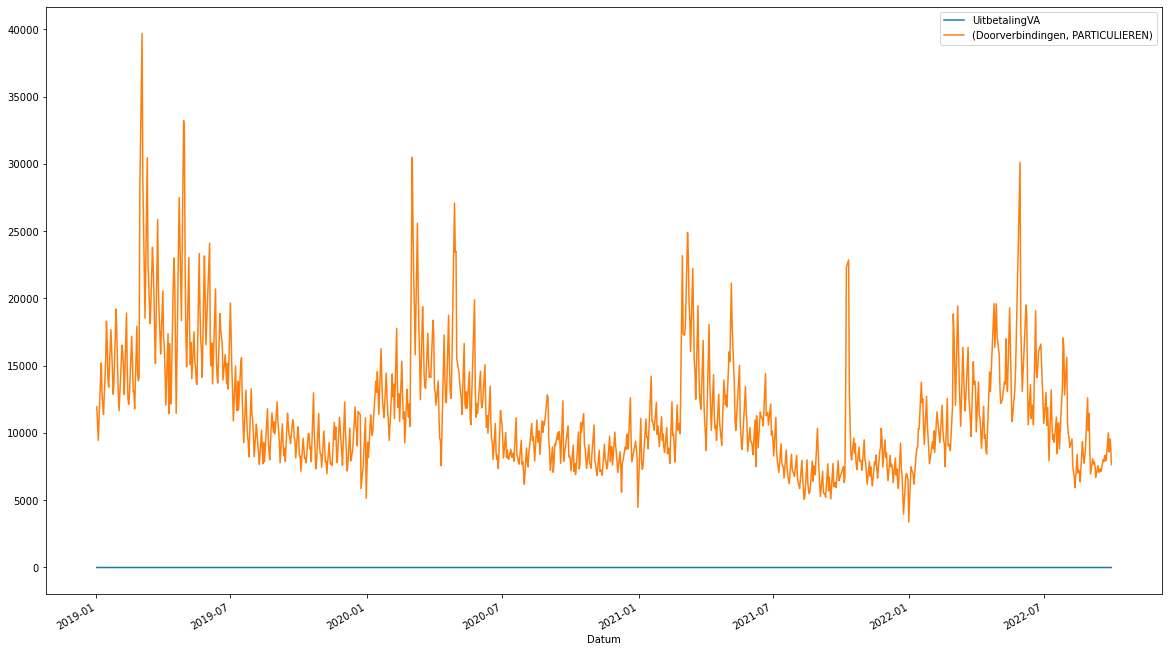

In [22]:
# Visualisatie effect uitbetalingsdatum op particulieren
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (20,12)
df_totaal_betalingen.set_index('Datum')[['UitbetalingVA', ('Doorverbindingen', 'PARTICULIEREN')]].plot()


In [23]:
lead_days = 5 # constant
temp_lead_days = 0
for i, datum in enumerate(df_totaal_betalingen['Datum']):
    if i+temp_lead_days < len( df_totaal_betalingen['UitbetalingVA']):
        if df_totaal_betalingen['UitbetalingVA'][i+temp_lead_days] == 1:
            df_totaal_betalingen['UitbetalingVA'][i] = temp_lead_days
            temp_lead_days -= 1
        if temp_lead_days == 0:
            temp_lead_days = lead_days

/tmp/ipykernel_143/1067305636.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_totaal_betalingen['UitbetalingVA'][i] = temp_lead_days


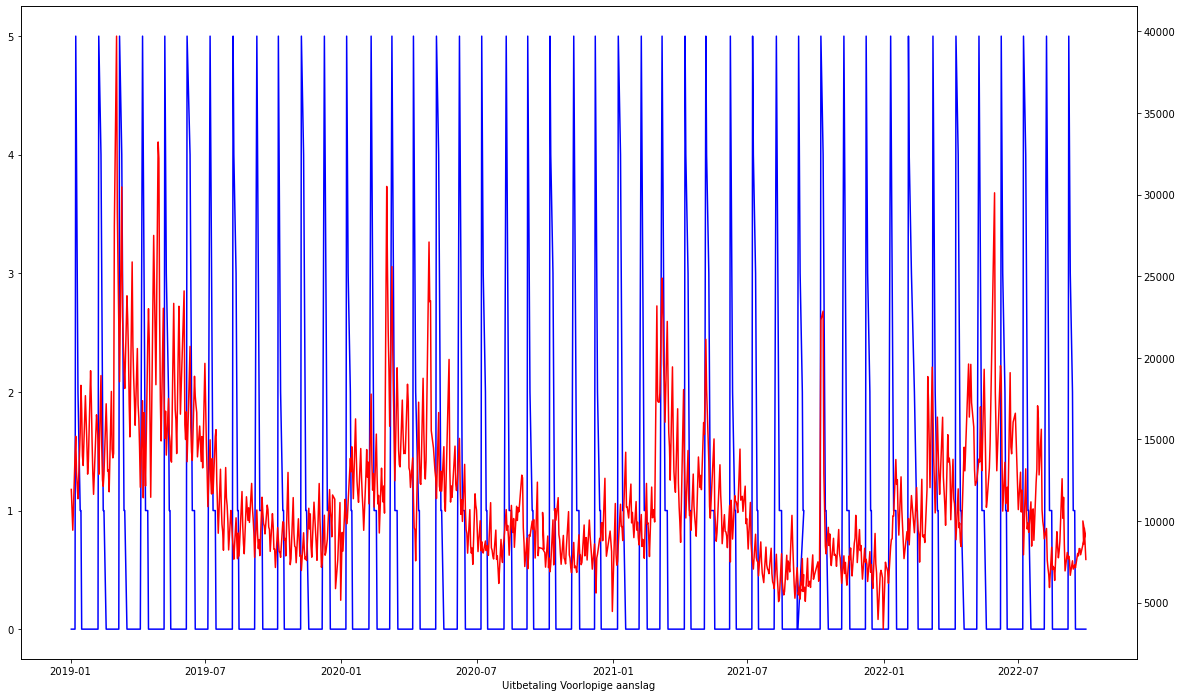

In [24]:
fig,ax = plt.subplots()
ax.plot(df_totaal_betalingen.set_index('Datum')['UitbetalingVA'], color = 'blue')
ax.set_xlabel('Uitbetaling Voorlopige aanslag') 

ax2 = ax.twinx()

ax2.plot(df_totaal_betalingen.set_index('Datum')[('Doorverbindingen', 'PARTICULIEREN')], color = 'red')
ax2.set_xlabel('Doorverbindingen Particulieren')

plt.show()

/opt/conda/lib/python3.9/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


<AxesSubplot:xlabel='Datum'>

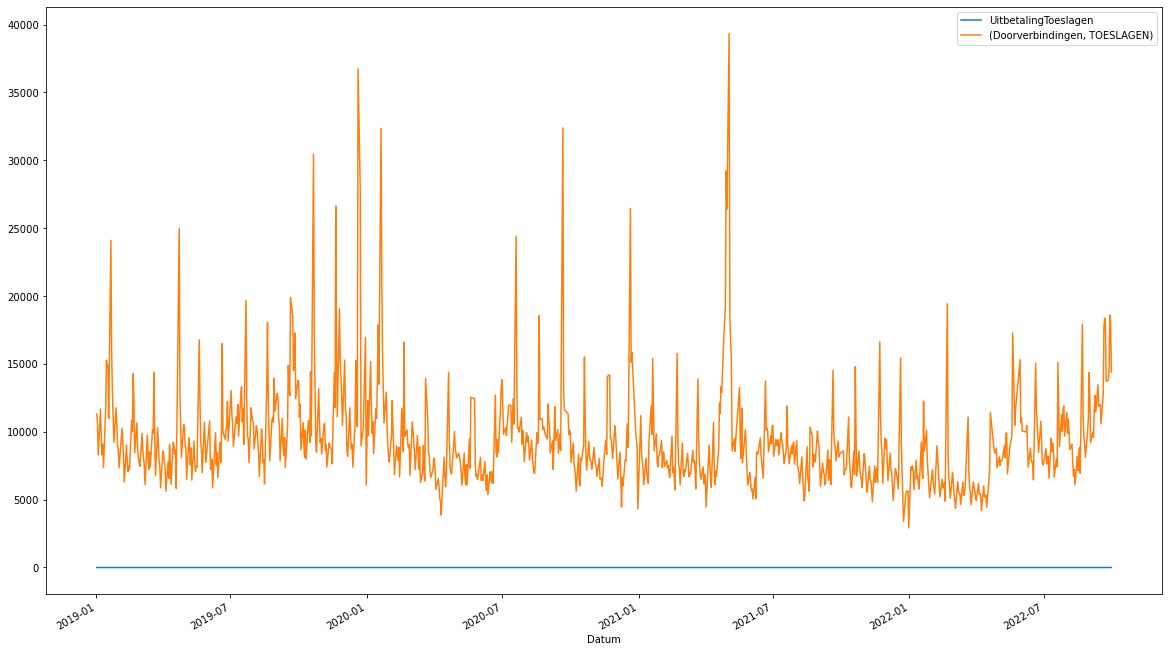

In [25]:
df_totaal_betalingen.set_index('Datum')[['UitbetalingToeslagen', ('Doorverbindingen', 'TOESLAGEN')]].plot()

In [26]:
lead_days = 7 # constant
temp_lead_days = 0
for i, datum in enumerate(df_totaal_betalingen['Datum']):
    if i+temp_lead_days < len( df_totaal_betalingen['UitbetalingToeslagen']):
        if df_totaal_betalingen['UitbetalingToeslagen'][i+temp_lead_days] == 1:
            df_totaal_betalingen['UitbetalingToeslagen'][i] = temp_lead_days
            temp_lead_days -= 1
        if temp_lead_days == 0:
            temp_lead_days = lead_days

/tmp/ipykernel_143/273827861.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_totaal_betalingen['UitbetalingToeslagen'][i] = temp_lead_days


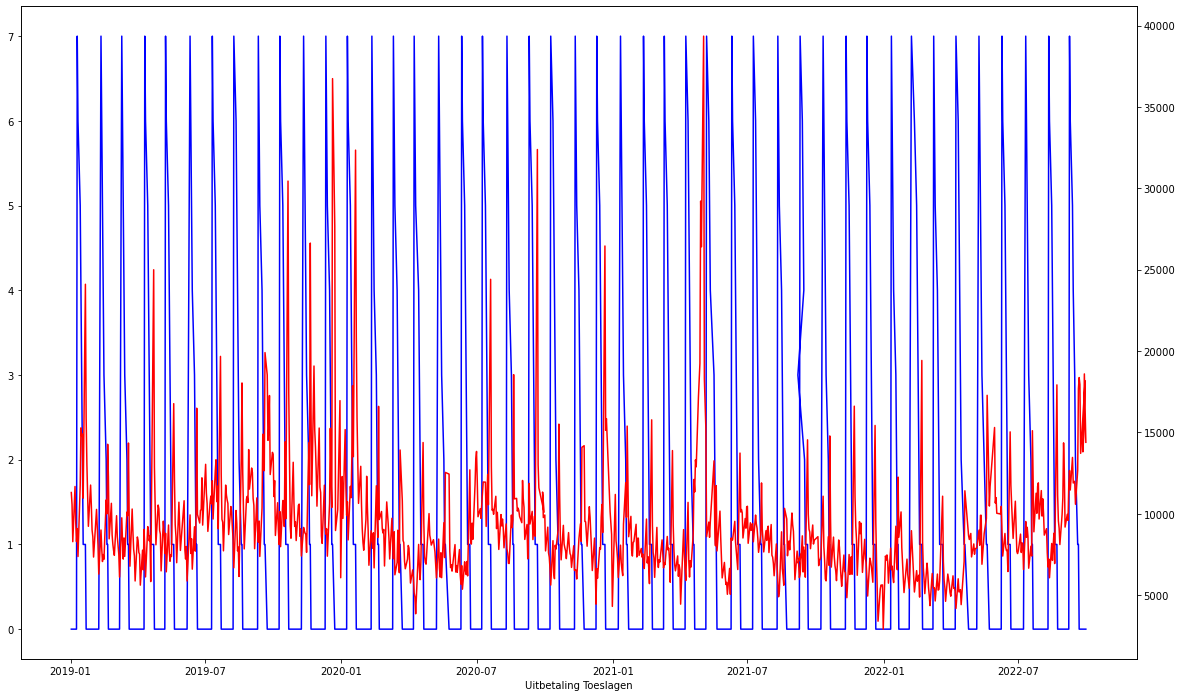

In [27]:
fig,ax = plt.subplots()
ax.plot(df_totaal_betalingen.set_index('Datum')['UitbetalingToeslagen'], color = 'blue')
ax.set_xlabel('Uitbetaling Toeslagen') 

ax2 = ax.twinx()

ax2.plot(df_totaal_betalingen.set_index('Datum')[('Doorverbindingen', 'TOESLAGEN')], color = 'red')
ax2.set_xlabel('Doorverbindingen Toeslagen')

plt.show()

##### Prinsjesdag

In [28]:
# Prinsjesdag: elke 3e dinsdag van september
prinsjesdagen = []
import math

for i, datum in enumerate(df_totaal['Datum']):
    if df_totaal['Maand'][i] == 9:
        if math.ceil(df_totaal['Datum'][i].day/7 ) == 3:
            if df_totaal['Datum'][i].weekday() == 1:
                prinsjesdagen.append(df_totaal['Datum'][i])


In [29]:
df_totaal_betalingen['Prinsjesdag'] = 0
lead_days = 28 # constant
is_gezien_datum = False
temp_lead_days = 0
for i, datum in enumerate(df_totaal_betalingen['Datum']):
    
    if datum in prinsjesdagen:
        df_totaal_betalingen['Prinsjesdag'][i] = 1
        is_gezien_datum = True
        temp_lead_days = 0

    if is_gezien_datum:
        if temp_lead_days <= lead_days:
            df_totaal_betalingen['Prinsjesdag'][i] = temp_lead_days
            temp_lead_days += 1
        else:
            is_gezien_datum = False
df_totaal_betalingen_prinsjesdag = df_totaal_betalingen

#df_totaal_betalingen_prinsjesdag['Prinsjesdag'] = df_totaal_betalingen_prinsjesdag['Prinsjesdag'] * 500

/tmp/ipykernel_143/148079755.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_totaal_betalingen['Prinsjesdag'][i] = 1
/tmp/ipykernel_143/148079755.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_totaal_betalingen['Prinsjesdag'][i] = temp_lead_days


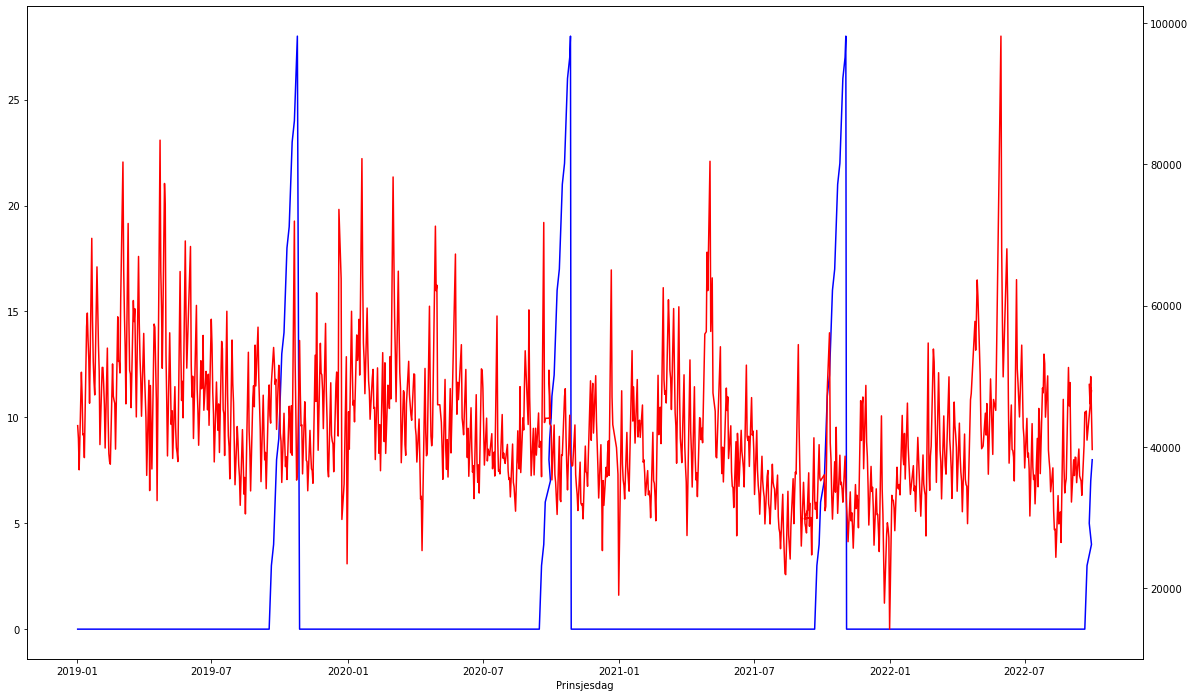

In [30]:
# Is er een effect op het aantal oproepen na prinsjesdag? Daar lijkt het niet op..
fig,ax = plt.subplots()
ax.plot(df_totaal_betalingen_prinsjesdag.set_index('Datum')['Prinsjesdag'], color = 'blue')
ax.set_xlabel('Prinsjesdag') 

ax2 = ax.twinx()

ax2.plot(df_totaal_betalingen_prinsjesdag.set_index('Datum')[('Doorverbindingen', 'TOTAAL')], color = 'red')
ax2.set_xlabel('Doorverbindingen Intermediairs')

plt.show()

In [31]:
prinsjesdagen

[Timestamp('2019-09-17 00:00:00'),
 Timestamp('2020-09-15 00:00:00'),
 Timestamp('2021-09-21 00:00:00'),
 Timestamp('2022-09-20 00:00:00')]

##### Schoolvakanties

In [32]:
# bron: https://opendata.rijksoverheid.nl/v1/infotypes/schoolholidays?output=json

In [33]:
f = open('schoolholidays.json',)
df_schoolvakanties_20192020 = pd.DataFrame(json.load(f)[0]['content'][0]['vacations'])

In [34]:
f = open('schoolholidays.json',)
df_schoolvakanties_20202021 = pd.DataFrame(json.load(f)[1]['content'][0]['vacations'])

In [35]:
f = open('schoolholidays.json',)
df_schoolvakanties_20212022 = pd.DataFrame(json.load(f)[2]['content'][0]['vacations'])

In [36]:
vakanties_totaal = pd.concat([df_schoolvakanties_20192020, df_schoolvakanties_20202021, df_schoolvakanties_20212022])
vakanties_totaal['type'] = vakanties_totaal['type'].apply(lambda x:x.replace('\n', '').strip())
vakanties_totaal.index = np.arange(0,len(vakanties_totaal['type']))

In [37]:
min_startdate = []
max_enddate = []
for i, rows in enumerate(vakanties_totaal['regions']):
    startdates_per_row = []
    enddates_per_row = []
    for j, regions in enumerate(rows):
        start_date = regions['startdate']
        end_date = regions['enddate']
        startdates_per_row.append(start_date)
        enddates_per_row.append(end_date)
    min_startdate.append(min(startdates_per_row))
    max_enddate.append(max(enddates_per_row))
vakanties_totaal['min_startdatum'] = min_startdate#.apply(lambda x:x.split("T")[0])
vakanties_totaal['min_startdatum'] = vakanties_totaal['min_startdatum'].apply(lambda x:x.split("T")[0])
vakanties_totaal['max_enddatum'] = max_enddate
vakanties_totaal['max_enddatum'] = vakanties_totaal['max_enddatum'].apply(lambda x:x.split("T")[0])

In [38]:
# bron: http://defeestdagen.com/schoolvakanties-2018-2019/
types_begin2019 = ['Kerstvakantie', 'Voorjaarsvakantie', 'Meivakantie', 'Zomervakantie']
compulsorydates = [True, False, True, True]
regions = [0,0,0,0]
min_startdatum = ['2018-12-22', '2019-02-16', '2019-04-27', '2019-07-06']
max_enddatum = ['2019-01-06', '2019-03-02', '2019-05-05', '2019-09-01']

vakanties_begin2019 = pd.DataFrame({'type':types_begin2019,
                                    'compulsorydates':compulsorydates,
                                    'regions':regions,
                                    'min_startdatum':min_startdatum,
                                    'max_enddatum':max_enddatum})

In [39]:
df_vakanties_final = pd.concat([vakanties_begin2019, vakanties_totaal]).reset_index(drop = True)

In [40]:
df_vakanties_final

,type,compulsorydates,regions,min_startdatum,max_enddatum
0,Kerstvakantie,True,0,2018-12-22,2019-01-06
1,Voorjaarsvakantie,False,0,2019-02-16,2019-03-02
2,Meivakantie,True,0,2019-04-27,2019-05-05
3,Zomervakantie,True,0,2019-07-06,2019-09-01
4,Herfstvakantie,false,"[{'region': 'noord', 'startdate': '2019-10-19T...",2019-10-12,2019-10-27
5,Kerstvakantie,true,"[{'region': 'heel Nederland', 'startdate': '20...",2019-12-21,2020-01-05
6,Voorjaarsvakantie,false,"[{'region': 'noord', 'startdate': '2020-02-15T...",2020-02-15,2020-03-01
7,Meivakantie,true,"[{'region': 'heel Nederland', 'startdate': '20...",2020-04-25,2020-05-03
8,Zomervakantie,true,"[{'region': 'noord', 'startdate': '2020-07-04T...",2020-07-04,2020-08-30
9,Herfstvakantie,false,"[{'region': 'noord', 'startdate': '2020-10-10T...",2020-10-10,2020-10-25


In [41]:
df_totaal_betalingen_prinsjesdag['Schoolvakantie'] = 0
for i, startdatum in enumerate(df_vakanties_final['min_startdatum']):
    daterange_i = pd.date_range(startdatum, df_vakanties_final['max_enddatum'][i])
    for j, df_datum in enumerate(df_totaal_betalingen_prinsjesdag['Datum']):
        if df_datum in daterange_i:
            df_totaal_betalingen_prinsjesdag['Schoolvakantie'][j] = 1
df_tot_bet_prins_vak = df_totaal_betalingen_prinsjesdag

/tmp/ipykernel_143/3541869368.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_totaal_betalingen_prinsjesdag['Schoolvakantie'][j] = 1


/opt/conda/lib/python3.9/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


<AxesSubplot:xlabel='Datum'>

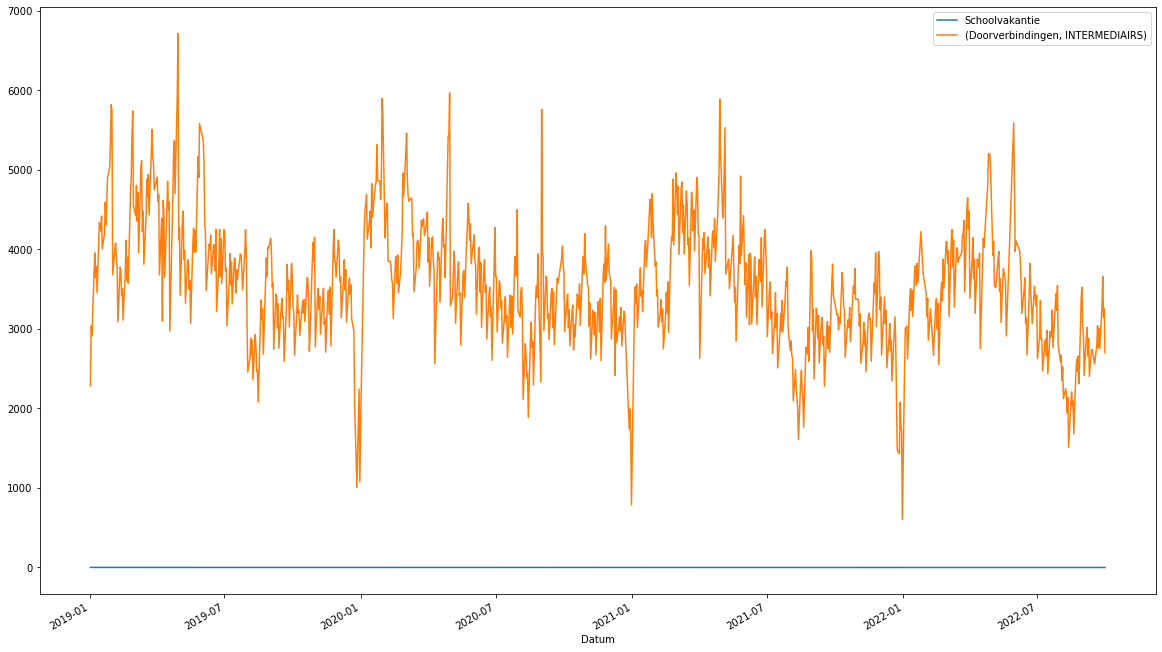

In [42]:
# Visualisatie schoolvakanties op intermediairs
df_tot_bet_prins_vak.set_index('Datum')[['Schoolvakantie', ('Doorverbindingen', 'INTERMEDIAIRS')]].plot()

/opt/conda/lib/python3.9/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


<AxesSubplot:xlabel='Datum'>

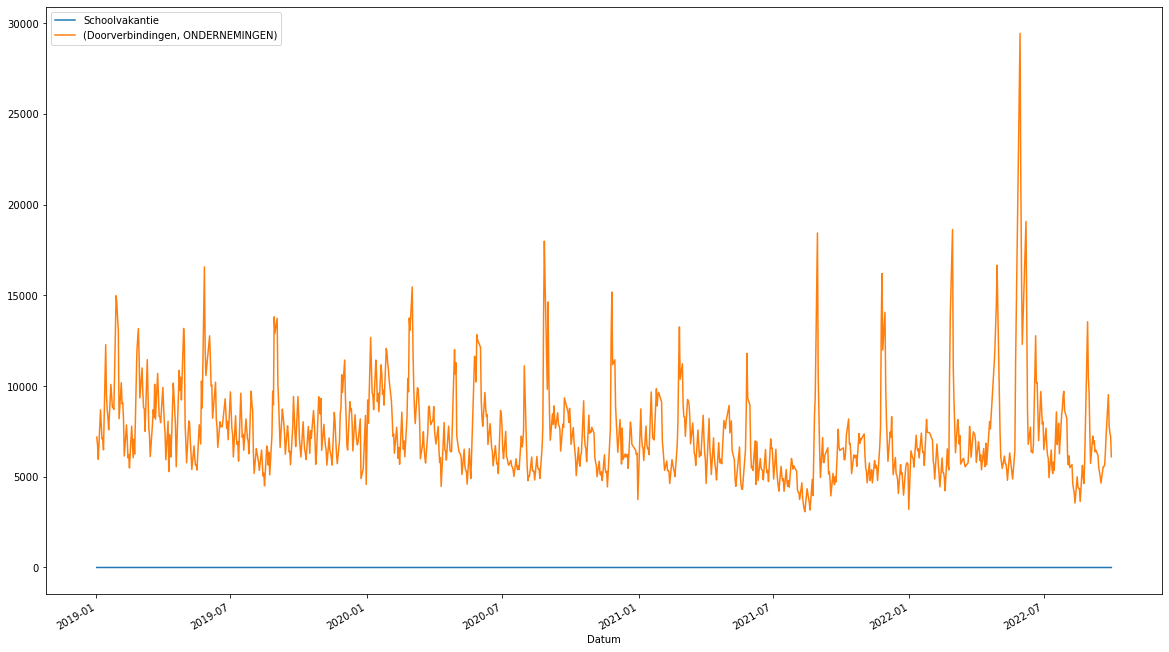

In [43]:
# Visualisatie schoolvakanties op ondernemingen
df_tot_bet_prins_vak.set_index('Datum')[['Schoolvakantie', ('Doorverbindingen', 'ONDERNEMINGEN')]].plot()

/opt/conda/lib/python3.9/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


<AxesSubplot:xlabel='Datum'>

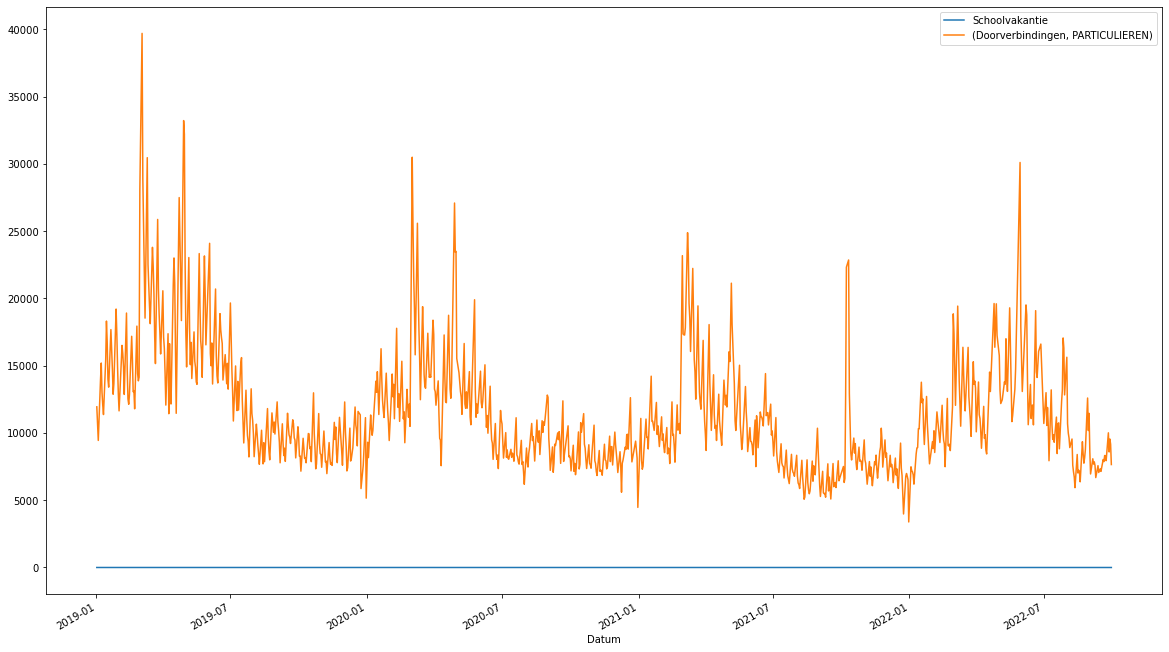

In [44]:
# Visualisatie schoolvakanties op ondernemingen
df_tot_bet_prins_vak.set_index('Datum')[['Schoolvakantie', ('Doorverbindingen', 'PARTICULIEREN')]].plot()

##### Nationale feestdagen

In [45]:
from workalendar.europe import Netherlands
cal = Netherlands()
feestdagen = []
werkdagen_na_feestdagen = []
jaren = [2019,2020,2021,2022]
for jaar in jaren:
    for feestdag in cal.holidays(jaar):
        feestdagen.append(feestdag)
        pd.to_datetime(werkdagen_na_feestdagen.append(cal.add_working_days(feestdag[0],1)))

In [46]:
df_werkdagen_na_feestdagen = pd.DataFrame(columns=['Werkdag'])
unieke_werkdagen = [*set(werkdagen_na_feestdagen)]

In [47]:
df_tot_bet_prins_vak['WerkdagNaFeestdag'] = 0
for i, df_datum in enumerate(df_tot_bet_prins_vak['Datum']):
    if df_datum in unieke_werkdagen:
        df_tot_bet_prins_vak['WerkdagNaFeestdag'][i] = 1
df_tot_bet_prins_vak_feest = df_tot_bet_prins_vak

/tmp/ipykernel_143/2779342164.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tot_bet_prins_vak['WerkdagNaFeestdag'][i] = 1


/opt/conda/lib/python3.9/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


<AxesSubplot:xlabel='Datum'>

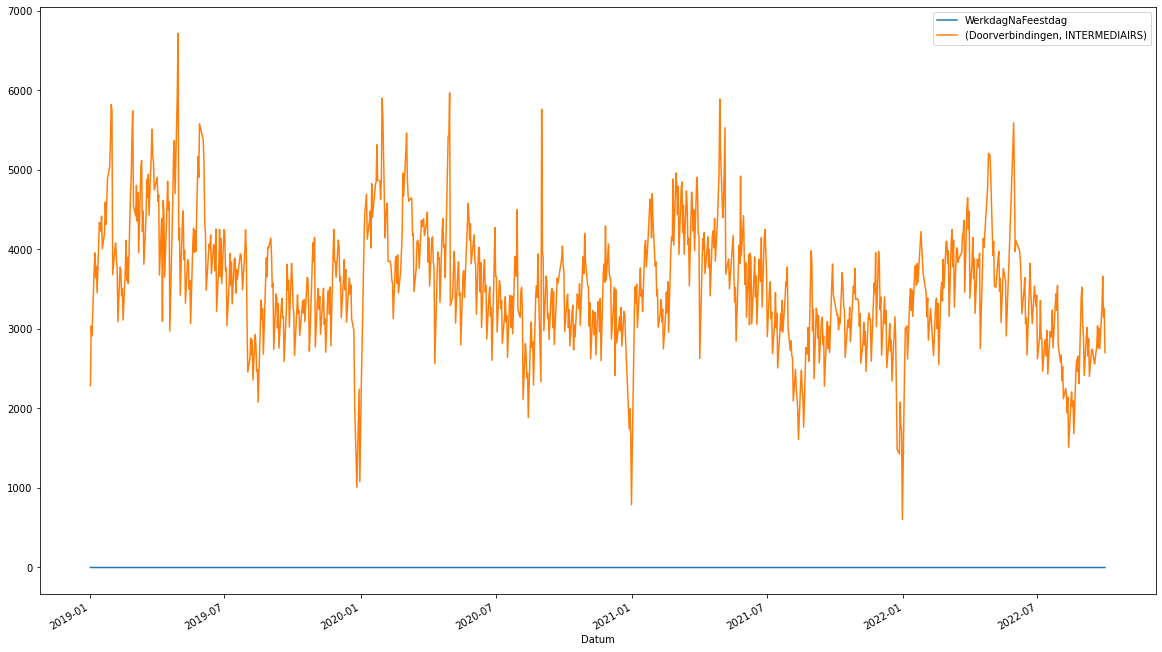

In [48]:
# Visualisatie nationale feestdagen op particulieren
df_tot_bet_prins_vak_feest.set_index('Datum')[['WerkdagNaFeestdag', ('Doorverbindingen', 'INTERMEDIAIRS')]].plot()

##### Aangifte deadlines

1. omzetbelasting: laatste dag van de maand, 
- per kwartaal aangifte: laatste dag van de maand volgend op kwartaal
- per jaar aangifte: 31 maart
- bron: https://www.belastingdienst.nl/wps/wcm/connect/nl/btw/content/uiterste-aangifte-en-betaaldatums

2. inkomstenbelasting: 
- bron: https://www.rijksoverheid.nl/actueel/nieuws/2020/02/26/start-aangiftecampagne-voorjaar-2020#:~:text=Vanaf%201%20maart%20doen%20miljoenen,geld%20terugkrijgen%20of%20moeten%20betalen.
- bron 2: https://www.rijksoverheid.nl/documenten/publicaties/2021/05/11/aangiftecampagne

3. loonbelasting: elke maand of elke 4 weken
- bron: https://www.belastingdienst.nl/wps/wcm/connect/nl/personeel-en-loon/content/loonaangifte-aangifte-loonheffingen

4. vennootschapsbelasting: normaliter 1 juni van het volgende kalenderjaar
- bron: https://www.belastingdienst.nl/wps/wcm/connect/bldcontentnl/belastingdienst/zakelijk/winst/vennootschapsbelasting/aangifte_versturen/inleverdatum_aangifte_vennootschapsbelasting

5. motorrijtuigenbelasting: 28e van de maand incasso 
- bron: https://www.belastingdienst.nl/wps/wcm/connect/nl/auto-en-vervoer/content/motorrijtuigenbelasting-hoe-betalen

dividendbelasting, schenkbelasting, erfbelasting mrb: geen vast moment

In [49]:
import datetime

In [50]:
# 1. omzetbelasting: laatste dag van de maand
df_omzetbelasting_maand = pd.DataFrame(columns = ['DeadlineOmzetbelastingMaand'])
for year in range(2019,2023):
    for month in range(1,13):
        prev_day=27
        for day in range(27,32):
            try:
                datetime.date(year, month, day)
                if prev_day<day:
                    prev_day=day        
            except:
                break
        df_omzetbelasting_maand = df_omzetbelasting_maand.append({"DeadlineOmzetbelastingMaand":datetime.date(year, month, prev_day)}, ignore_index=True)
df_omzetbelasting_maand = df_omzetbelasting_maand.append({"DeadlineOmzetbelastingMaand":datetime.date(2019, 5, 29)}, ignore_index=True)
df_omzetbelasting_maand = df_omzetbelasting_maand.append({"DeadlineOmzetbelastingMaand":datetime.date(2021, 9, 29)}, ignore_index=True)
df_omzetbelasting_maand = df_omzetbelasting_maand.append({"DeadlineOmzetbelastingMaand":datetime.date(2022, 1, 28)}, ignore_index=True)

In [51]:
# 1. omzetbelasting: per kwartaal: laatste dag van de maand volgend op kwartaal
df_omzetbelasting_kwartaal = pd.DataFrame(columns = ['DeadlineOmzetbelastingKwartaal'])
ob_kwartaal_list = []
for jaar in range(2019,2023):
    for aangiftedatum in ['01-31', '04-30', '07-31', '10-31']:
        datum = str(jaar) + '-' + aangiftedatum
        #print(datum)
        ob_kwartaal_list.append(datum)
df_omzetbelasting_kwartaal['DeadlineOmzetbelastingKwartaal'] = ob_kwartaal_list
# df_omzetbelasting_kwartaal

In [52]:
# 1. omzetbelasting: per jaar: 31 maart
df_omzetbelasting_jaar = pd.DataFrame(columns = ['DeadlineOmzetbelastingJaar'])
ob_jaar_list = []
for jaar in range(2019, 2023):
    aangiftedatum_jaar = '03-31'
    datum_jaar = str(jaar) + '-' + aangiftedatum_jaar
    ob_jaar_list.append(datum_jaar)
df_omzetbelasting_jaar['DeadlineOmzetbelastingJaar'] = ob_jaar_list
# df_omzetbelasting_jaar

In [53]:
# OB: als de deadline in het weekend valt, dan zetten we de datum op de dichtstbijzijnde eerdere werkdag
for i, date in enumerate(list(df_omzetbelasting_maand['DeadlineOmzetbelastingMaand'])):
    if cal.is_working_day(pd.to_datetime(date)) == False:
        new_date = cal.add_working_days(pd.to_datetime(date), -1)
        df_omzetbelasting_maand['DeadlineOmzetbelastingMaand'][i] = new_date
        
for i, date in enumerate(list(df_omzetbelasting_kwartaal['DeadlineOmzetbelastingKwartaal'])):
    if cal.is_working_day(pd.to_datetime(date)) == False:
        new_date = cal.add_working_days(pd.to_datetime(date), -1)
        df_omzetbelasting_kwartaal['DeadlineOmzetbelastingKwartaal'][i] = new_date

for i, date in enumerate(list(df_omzetbelasting_jaar['DeadlineOmzetbelastingJaar'])):
    if cal.is_working_day(pd.to_datetime(date)) == False:
        new_date = cal.add_working_days(pd.to_datetime(date), -1)
        df_omzetbelasting_jaar['DeadlineOmzetbelastingJaar'][i] = new_date

In [54]:
# Check: alle OB aangifte data zijn op werkdagen: 
for i in list(df_omzetbelasting_maand['DeadlineOmzetbelastingMaand']):
    if cal.is_working_day(pd.to_datetime(i)) == False:
        print(i)

In [55]:
df_tot_bet_prins_vak_feest['DeadlineOmzetbelasting'] = 0
for i, df_datum in enumerate(df_tot_bet_prins_vak_feest['Datum']):
    if df_datum in list(df_omzetbelasting_maand['DeadlineOmzetbelastingMaand']):
        df_tot_bet_prins_vak_feest['DeadlineOmzetbelasting'][i] = 1
    elif df_datum in list(df_omzetbelasting_kwartaal['DeadlineOmzetbelastingKwartaal']):
        df_tot_bet_prins_vak_feest['DeadlineOmzetbelasting'][i] = 1
    elif df_datum in list(df_omzetbelasting_jaar['DeadlineOmzetbelastingJaar']):
        df_tot_bet_prins_vak_feest['DeadlineOmzetbelasting'][i] = 1
df_tot_bet_prins_vak_feest_ob = df_tot_bet_prins_vak_feest

/tmp/ipykernel_143/347917635.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tot_bet_prins_vak_feest['DeadlineOmzetbelasting'][i] = 1


In [56]:
#df_tot_bet_prins_vak_feest['DeadlineOmzetbelasting'] = 0
lead_days = 7 # constant
temp_lead_days = 0
for i, datum in enumerate(df_tot_bet_prins_vak_feest['Datum']):
    if i+temp_lead_days < len( df_tot_bet_prins_vak_feest['DeadlineOmzetbelasting']):
        if df_tot_bet_prins_vak_feest['DeadlineOmzetbelasting'][i+temp_lead_days] == 1:
            df_tot_bet_prins_vak_feest['DeadlineOmzetbelasting'][i] = temp_lead_days
            temp_lead_days -= 1
        if temp_lead_days == 0:
            temp_lead_days = lead_days

/tmp/ipykernel_143/2673489090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tot_bet_prins_vak_feest['DeadlineOmzetbelasting'][i] = temp_lead_days


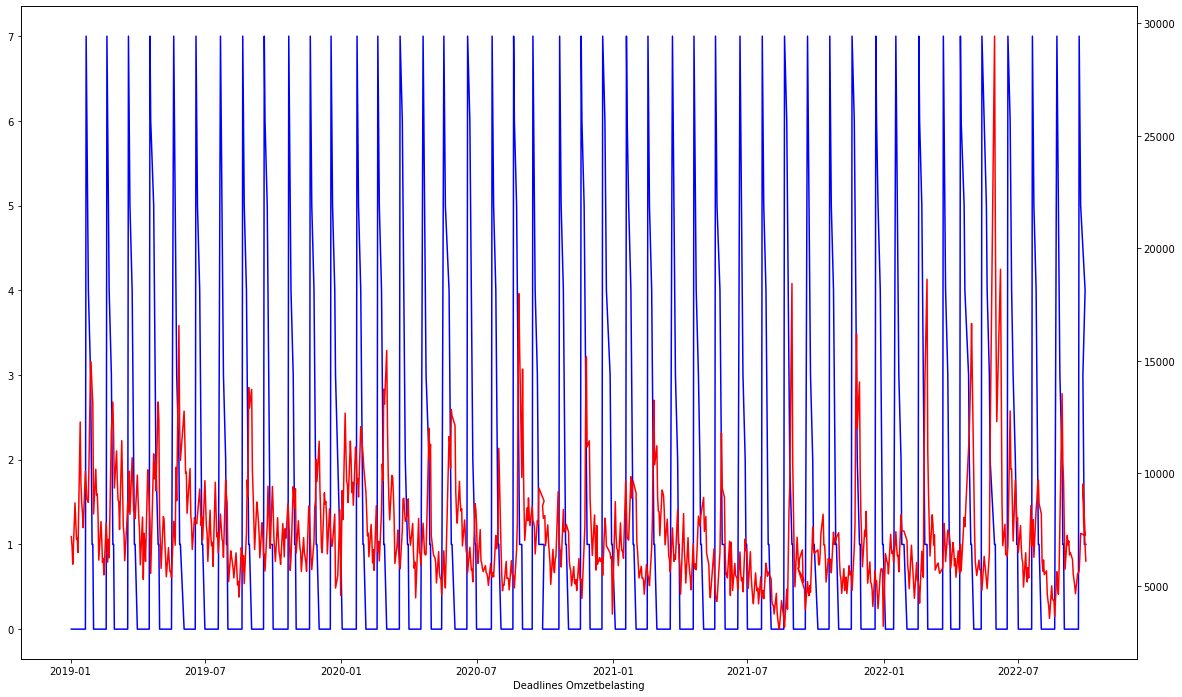

In [57]:
fig,ax = plt.subplots()
ax.plot(df_tot_bet_prins_vak_feest_ob.set_index('Datum')['DeadlineOmzetbelasting'], color = 'blue')
ax.set_xlabel('Deadlines Omzetbelasting') 

ax2 = ax.twinx()

ax2.plot(df_tot_bet_prins_vak_feest_ob.set_index('Datum')[('Doorverbindingen', 'ONDERNEMINGEN')], color = 'red')
ax2.set_xlabel('Doorverbindingen Ondernemingen')

#plt.legend()
plt.show()

In [58]:
# 2. inkomstenbelasting: 1 maart t/m 1 mei behalve in 2021: t/m 8 mei 2021
daterange_ib_2019 = pd.date_range(start = '2019-03-01', end = '2019-05-01')
daterange_ib_2020 = pd.date_range(start = '2020-03-01', end = '2020-05-01')
daterange_ib_2021 = pd.date_range(start = '2021-03-01', end = '2021-05-08')
daterange_ib_2022 = pd.date_range(start = '2022-03-01', end = '2022-05-01')

df_aangifte_ib = pd.DataFrame(list(zip(daterange_ib_2019, daterange_ib_2020, daterange_ib_2021, daterange_ib_2022))).stack().reset_index().rename(columns = {0:'DeadlineInkomstenbelasting'}).sort_values('DeadlineInkomstenbelasting').reset_index().drop(axis = 0, columns = ['index', 'level_0', 'level_1'])

# IB: als de deadline in het weekend valt, dan zetten we de datum op de dichtstbijzijnde eerdere werkdag
for i, date in enumerate(list(df_aangifte_ib['DeadlineInkomstenbelasting'])):
    if cal.is_working_day(pd.to_datetime(date)) == False:
        new_date = cal.add_working_days(date, -1)
        df_aangifte_ib['DeadlineInkomstenbelasting'][i] = new_date

In [59]:
# Check: alle IB aangifte data zijn op werkdagen: 
for i in list(df_aangifte_ib['DeadlineInkomstenbelasting']):
    if cal.is_working_day(pd.to_datetime(i)) == False:
        print(i)

In [60]:
df_tot_bet_prins_vak_feest_ob['DeadlineInkomstenbelasting'] = 0
for i, df_datum in enumerate(df_tot_bet_prins_vak_feest_ob['Datum']):
    if df_datum in list(df_aangifte_ib['DeadlineInkomstenbelasting']):
        df_tot_bet_prins_vak_feest_ob['DeadlineInkomstenbelasting'][i] = 1
df_tot_bet_prins_vak_feest_ob_ib = df_tot_bet_prins_vak_feest_ob

/tmp/ipykernel_143/4090400430.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tot_bet_prins_vak_feest_ob['DeadlineInkomstenbelasting'][i] = 1


In [61]:
# 3. loonbelasting 
# 3.1 Maandaangiften
import datetime
df_loonaangifte_maand = pd.DataFrame(columns = ['DeadlineLoonbelastingMaand'])#:eerste_aangiftedata_maand})
for year in range(2019,2023):
    for month in range(1,13):
        prev_day=27
        for day in range(27,32):
            try:
                datetime.date(year, month, day)
                if prev_day<day:
                    prev_day=day        
            except:
                break
        df_loonaangifte_maand = df_loonaangifte_maand.append({"DeadlineLoonbelastingMaand":datetime.date(year, month, prev_day)}, ignore_index=True)
df_loonaangifte_maand

# LB als de deadline in het weekend valt, dan zetten we de datum op de dichtstbijzijnde eerdere werkdag
for i, date in enumerate(list(df_loonaangifte_maand['DeadlineLoonbelastingMaand'])):
    if cal.is_working_day(pd.to_datetime(date)) == False:
        new_date = cal.add_working_days(date, -1)
        df_loonaangifte_maand['DeadlineLoonbelastingMaand'][i] = new_date
df_loonaangifte_maand = df_loonaangifte_maand.append({"DeadlineLoonbelastingMaand":datetime.date(2019, 5, 29)}, ignore_index=True)
df_loonaangifte_maand = df_loonaangifte_maand.append({"DeadlineLoonbelastingMaand":datetime.date(2021, 9, 29)}, ignore_index=True)
df_loonaangifte_maand = df_loonaangifte_maand.append({"DeadlineLoonbelastingMaand":datetime.date(2022, 1, 28)}, ignore_index=True)

In [62]:
# Check: alle loonaangifte data zijn op werkdagen: 
for i in list(df_loonaangifte_maand['DeadlineLoonbelastingMaand']):
    if cal.is_working_day(pd.to_datetime(i)) == False:
        print(i)

In [63]:
# 3. loonbelasting 
# 3.1 4 weken aangiften
loonaangifte_4weken_2019 = ['2019-01-02', '2019-01-31', '2019-02-27', '2019-03-25',\
                            '2019-04-24', '2019-05-21', '2019-06-19', '2019-07-16',\
                            '2019-08-14', '2019-09-11', '2019-10-08', '2019-11-06',\
                            '2019-12-03']

loonaangifte_4weken_2020 = ['2020-01-02', '2020-01-31', '2020-02-26', '2020-03-23',\
                            '2020-04-22', '2020-05-19', '2020-06-17', '2020-07-14',\
                            '2020-08-12', '2020-09-09', '2020-10-06', '2020-11-04',\
                            '2020-12-01', '2020-29-12']

loonaangifte_4weken_2021 = ['2021-01-29', '2021-02-26', '2021-03-26', '2021-04-28',\
                            '2021-05-25', '2021-06-23', '2021-07-20', '2021-08-18',\
                            '2021-09-15', '2021-10-12', '2021-11-01', '2021-12-07']

loonaangifte_4weken_2022 = ['2022-01-05', '2022-01-31', '2022-02-28', '2022-03-25',\
                            '2022-04-26', '2022-05-24', '2022-06-22', '2022-07-19',\
                            '2022-08-17', '2022-09-13', '2022-10-11', '2022-11-09',\
                            '2022-12-06']
df_loonaangifte_4weken = pd.DataFrame(list(zip(loonaangifte_4weken_2019, loonaangifte_4weken_2020, loonaangifte_4weken_2021, loonaangifte_4weken_2022))).stack().reset_index().rename(columns = {0:'DeadlineLoonbelasting4weken'}).sort_values('DeadlineLoonbelasting4weken').reset_index().drop(axis = 0, columns = ['index', 'level_0', 'level_1'])
# df_loonaangifte_4weken

df_loonaangifte_4weken['DeadlineLoonbelasting4weken'] = df_loonaangifte_4weken['DeadlineLoonbelasting4weken'].apply(lambda x:pd.to_datetime(x))
# Als de deadline in het weekend valt, dan zetten we de datum op de dichtstbijzijnde eerdere werkag
# Check: alle loonaangifte data zijn op werkdagen: 
for i in list(df_loonaangifte_4weken['DeadlineLoonbelasting4weken']):
    if cal.is_working_day(pd.to_datetime(i)) == False:
        print(i)

In [64]:
df_tot_bet_prins_vak_feest_ob_ib['DeadlineLoonbelasting'] = 0
for i, df_datum in enumerate(df_tot_bet_prins_vak_feest_ob_ib['Datum']):
    if df_datum in list(df_loonaangifte_maand['DeadlineLoonbelastingMaand']):
        df_tot_bet_prins_vak_feest_ob_ib['DeadlineLoonbelasting'][i] = 1
    #elif df_datum in list(df_loonaangifte_4weken['DeadlineLoonbelasting4weken']):
    #    df_tot_bet_prins_vak_feest_ob_ib['DeadlineLoonbelasting'][i] = 1
df_tot_bet_prins_vak_feest_ob_ib_lb = df_tot_bet_prins_vak_feest_ob_ib

/tmp/ipykernel_143/1995546451.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tot_bet_prins_vak_feest_ob_ib['DeadlineLoonbelasting'][i] = 1


/opt/conda/lib/python3.9/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


<AxesSubplot:xlabel='Datum'>

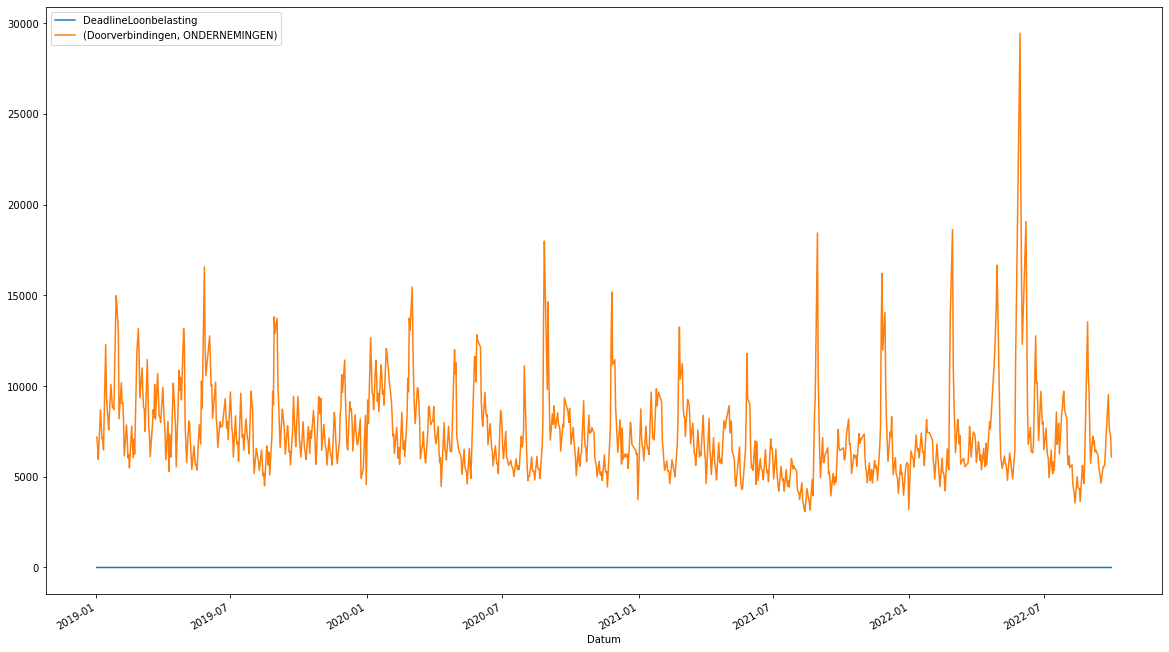

In [65]:
df_tot_bet_prins_vak_feest_ob_ib_lb.set_index('Datum')[['DeadlineLoonbelasting', ('Doorverbindingen', 'ONDERNEMINGEN')]].plot()

In [66]:
lead_days = 7 # constant
temp_lead_days = 0
for i, datum in enumerate(df_tot_bet_prins_vak_feest_ob_ib_lb['Datum']):
    if i+temp_lead_days < len( df_tot_bet_prins_vak_feest_ob_ib_lb['DeadlineLoonbelasting']):
        if df_tot_bet_prins_vak_feest_ob_ib_lb['DeadlineLoonbelasting'][i+temp_lead_days] == 1:
            df_tot_bet_prins_vak_feest_ob_ib_lb['DeadlineLoonbelasting'][i] = temp_lead_days
            temp_lead_days -= 1
        if temp_lead_days == 0:
            temp_lead_days = lead_days

/tmp/ipykernel_143/370725894.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tot_bet_prins_vak_feest_ob_ib_lb['DeadlineLoonbelasting'][i] = temp_lead_days


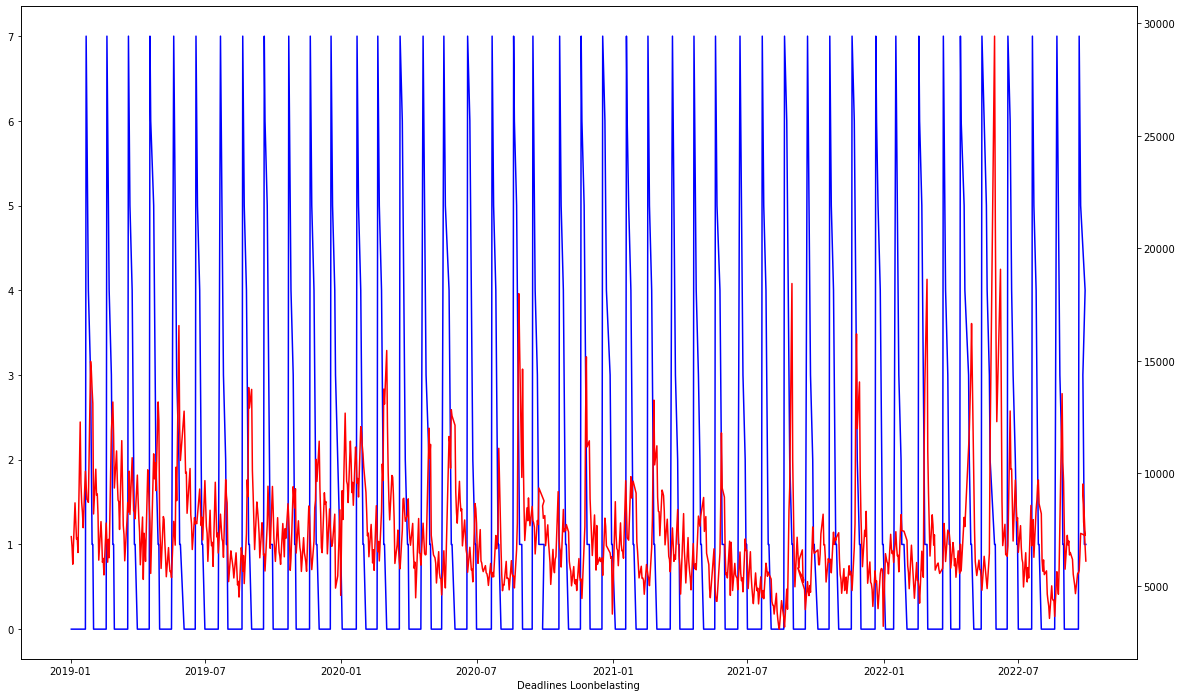

In [68]:
fig,ax = plt.subplots()
ax.plot(df_tot_bet_prins_vak_feest_ob_ib_lb.set_index('Datum')['DeadlineLoonbelasting'], color = 'blue')
ax.set_xlabel('Deadlines Loonbelasting') 

ax2 = ax.twinx()

ax2.plot(df_tot_bet_prins_vak_feest_ob_ib_lb.set_index('Datum')[('Doorverbindingen', 'ONDERNEMINGEN')], color = 'red')
ax2.set_xlabel('Doorverbindingen Ondernemingen')

plt.show()

In [69]:
# 4. vennootschapsbelasting: 1 juni
df_vpbaangifte = pd.DataFrame({'DeadlineVennootschapsbelasting':['2019-05-29', '2020-05-29', '2021-06-01', '2022-06-01']})
# df_vpbaangifte
for i in list(df_vpbaangifte['DeadlineVennootschapsbelasting']):
    if cal.is_working_day(pd.to_datetime(i)) == False:
        print(i)
# als de deadline in het weekend valt, dan zetten we de datum op de dichtstbijzijnde eerdere werkag

In [70]:
df_tot_bet_prins_vak_feest_ob_ib_lb['DeadlineVennootschapsbelasting'] = 0
for i, df_datum in enumerate(df_tot_bet_prins_vak_feest_ob_ib_lb['Datum']):
    if df_datum.date() in list(df_vpbaangifte['DeadlineVennootschapsbelasting'].apply(lambda x: pd.to_datetime(x).date())):

        df_tot_bet_prins_vak_feest_ob_ib_lb['DeadlineVennootschapsbelasting'][i] = 1
df_tot_bet_prins_vak_feest_ob_ib_lb_vpb = df_tot_bet_prins_vak_feest_ob_ib_lb 

/tmp/ipykernel_143/945841336.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tot_bet_prins_vak_feest_ob_ib_lb['DeadlineVennootschapsbelasting'][i] = 1


/opt/conda/lib/python3.9/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


<AxesSubplot:xlabel='Datum'>

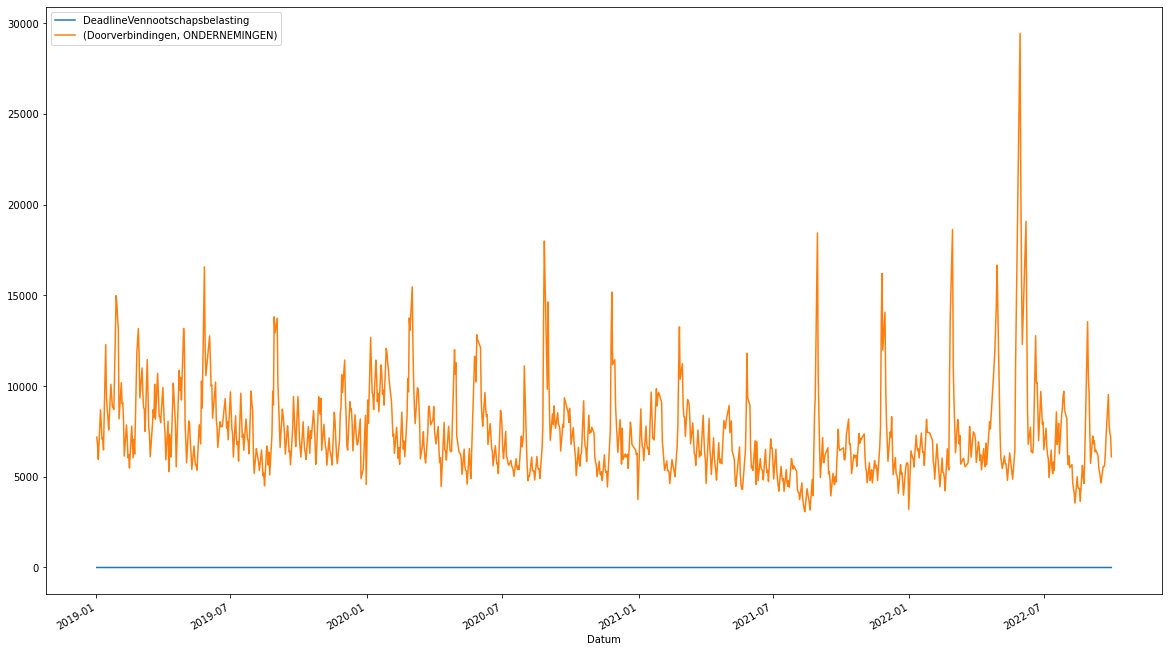

In [71]:
df_tot_bet_prins_vak_feest_ob_ib_lb.set_index('Datum')[['DeadlineVennootschapsbelasting', ('Doorverbindingen', 'ONDERNEMINGEN')]].plot()

In [72]:
lead_days = 28 # constant
temp_lead_days = 0
for i, datum in enumerate(df_tot_bet_prins_vak_feest_ob_ib_lb_vpb['Datum']):
    if i+temp_lead_days < len( df_tot_bet_prins_vak_feest_ob_ib_lb_vpb['DeadlineVennootschapsbelasting']):
        if df_tot_bet_prins_vak_feest_ob_ib_lb_vpb['DeadlineVennootschapsbelasting'][i+temp_lead_days] == 1:
            df_tot_bet_prins_vak_feest_ob_ib_lb_vpb['DeadlineVennootschapsbelasting'][i] = temp_lead_days
            temp_lead_days -= 1
        if temp_lead_days == 0:
            temp_lead_days = lead_days

/tmp/ipykernel_143/3544484826.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tot_bet_prins_vak_feest_ob_ib_lb_vpb['DeadlineVennootschapsbelasting'][i] = temp_lead_days


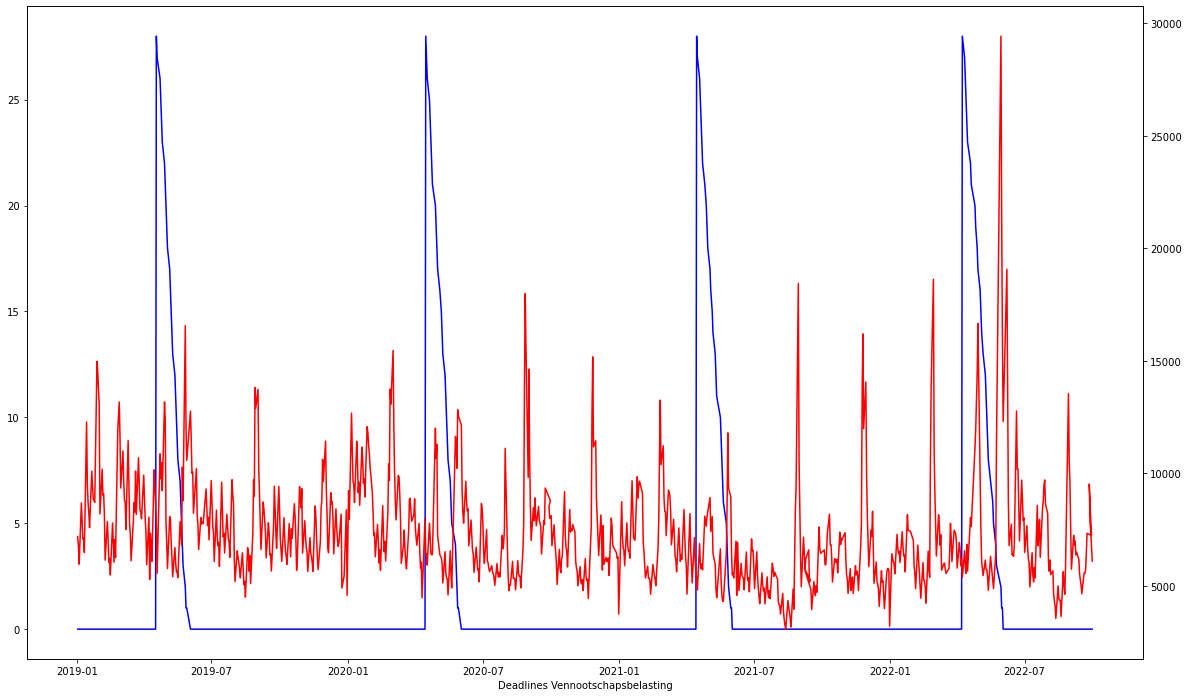

In [73]:
fig,ax = plt.subplots()
ax.plot(df_tot_bet_prins_vak_feest_ob_ib_lb_vpb.set_index('Datum')['DeadlineVennootschapsbelasting'], color = 'blue')
ax.set_xlabel('Deadlines Vennootschapsbelasting') 

ax2 = ax.twinx()

ax2.plot(df_tot_bet_prins_vak_feest_ob_ib_lb_vpb.set_index('Datum')[('Doorverbindingen', 'ONDERNEMINGEN')], color = 'red')
ax2.set_xlabel('Doorverbindingen Ondernemingen')

plt.show()

In [74]:
# 5. motorrijtuigenbelasting: 28e van de maand incasso 
df_motorrijtuigenbelasting = pd.DataFrame(columns = ['DeadlineMotorrijtuigenbelasting'])
mrb_datum_list = []
for year in range(2019,2023):
    for month in ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']:
        datum_mrb = str(year) + '-' + month + '-' + '28'
        datum2_mrb = pd.to_datetime(datum_mrb)
        mrb_datum_list.append(datum2_mrb)
        
df_motorrijtuigenbelasting['DeadlineMotorrijtuigenbelasting'] = mrb_datum_list
#df_motorrijtuigenbelasting

# MRB: als de deadline in het weekend valt, dan zetten we de datum op de dichtstbijzijnde eerdere werkdag
for i, date in enumerate(list(df_motorrijtuigenbelasting['DeadlineMotorrijtuigenbelasting'])):
    if cal.is_working_day(pd.to_datetime(date)) == False:
        new_date = cal.add_working_days(date, -1)
        df_motorrijtuigenbelasting['DeadlineMotorrijtuigenbelasting'][i] = new_date
        
df_motorrijtuigenbelasting = df_motorrijtuigenbelasting.append({"DeadlineMotorrijtuigenbelasting":datetime.date(2022, 5, 30)}, ignore_index=True)
df_motorrijtuigenbelasting = df_motorrijtuigenbelasting.append({"DeadlineMotorrijtuigenbelasting":datetime.date(2022, 6, 27)}, ignore_index=True)


In [75]:
for i in list(df_motorrijtuigenbelasting['DeadlineMotorrijtuigenbelasting']):
    if cal.is_working_day(pd.to_datetime(i)) == False:
        print(i)

In [76]:
df_tot_bet_prins_vak_feest_ob_ib_lb_vpb['IncassoMotorrijtuigenbelasting'] = 0
for i, df_datum in enumerate(df_tot_bet_prins_vak_feest_ob_ib_lb_vpb['Datum']):
    if df_datum in list(df_motorrijtuigenbelasting['DeadlineMotorrijtuigenbelasting']):
        df_tot_bet_prins_vak_feest_ob_ib_lb_vpb['IncassoMotorrijtuigenbelasting'][i] = 1
df_totaal_events = df_tot_bet_prins_vak_feest_ob_ib_lb_vpb 

/tmp/ipykernel_143/3485872294.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tot_bet_prins_vak_feest_ob_ib_lb_vpb['IncassoMotorrijtuigenbelasting'][i] = 1


/opt/conda/lib/python3.9/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


<AxesSubplot:xlabel='Datum'>

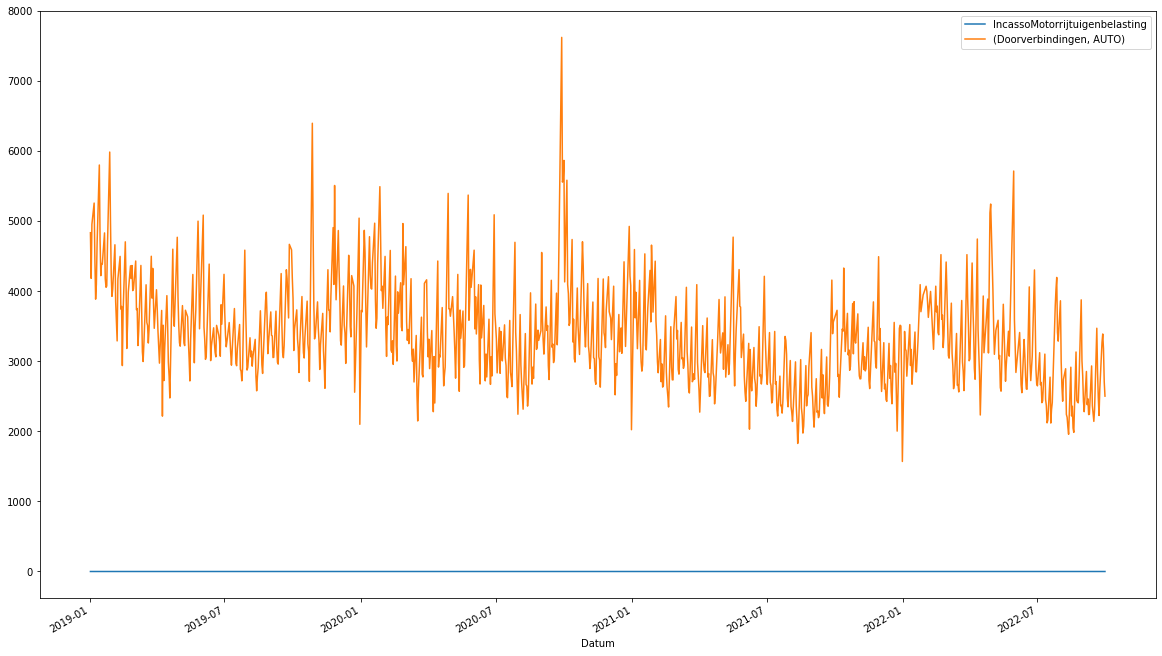

In [77]:
df_totaal_events.set_index('Datum')[['IncassoMotorrijtuigenbelasting', ('Doorverbindingen', 'AUTO')]].plot()

In [78]:
lead_days = 7 # constant
temp_lead_days = 0
for i, datum in enumerate(df_totaal_events['Datum']):
    if i+temp_lead_days < len(df_totaal_events['IncassoMotorrijtuigenbelasting']):
        if df_totaal_events['IncassoMotorrijtuigenbelasting'][i+temp_lead_days] == 1:
            df_totaal_events['IncassoMotorrijtuigenbelasting'][i] = temp_lead_days
            temp_lead_days -= 1
        if temp_lead_days == 0:
            temp_lead_days = lead_days



/tmp/ipykernel_143/3102168774.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_totaal_events['IncassoMotorrijtuigenbelasting'][i] = temp_lead_days


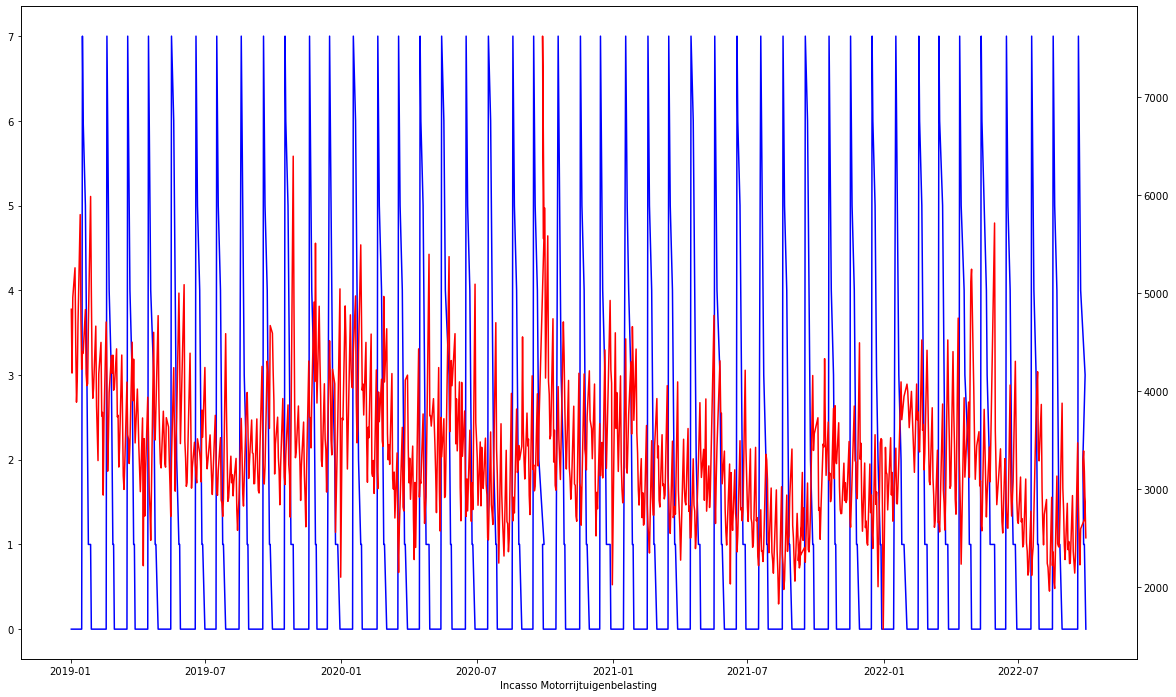

In [79]:
fig,ax = plt.subplots()
ax.plot(df_totaal_events.set_index('Datum')['IncassoMotorrijtuigenbelasting'], color = 'blue')
ax.set_xlabel('Incasso Motorrijtuigenbelasting') 

ax2 = ax.twinx()

ax2.plot(df_totaal_events.set_index('Datum')[('Doorverbindingen', 'AUTO')], color = 'red')
ax2.set_xlabel('Doorverbindingen Auto')

plt.show()

In [80]:
df_totaal_events

,Datum,UitbetalingVA,UitbetalingToeslagen,Binnengekomen bij Provider,Doorgeleid naar keuzemenu,Door beller opgehangen in menu,Automatisch behandeld in menu,"(Doorverbindingen, AUTO)","(Doorverbindingen, BUITENLAND)","(Doorverbindingen, DOUANE)",...,Dag,WeekNr,Prinsjesdag,Schoolvakantie,WerkdagNaFeestdag,DeadlineOmzetbelasting,DeadlineInkomstenbelasting,DeadlineLoonbelasting,DeadlineVennootschapsbelasting,IncassoMotorrijtuigenbelasting
0,2019-01-02,0.0,0.0,43396.0,43375.0,7557.0,1754.0,4834.0,2897.0,253.0,...,2,1,0,1,1,0,0,0,0,0
1,2019-01-03,0.0,0.0,36726.0,36710.0,4498.0,1406.0,4183.0,3268.0,230.0,...,3,1,0,1,0,0,0,0,0,0
2,2019-01-04,0.0,0.0,32900.0,32883.0,4336.0,1344.0,4955.0,2671.0,224.0,...,4,1,0,1,0,0,0,0,0,0
3,2019-01-07,0.0,0.0,47018.0,47005.0,6590.0,1993.0,5257.0,3706.0,288.0,...,7,2,0,0,0,0,0,0,0,0
4,2019-01-08,5.0,0.0,46532.0,46511.0,7650.0,2398.0,4458.0,3241.0,273.0,...,8,2,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
922,2022-09-29,0.0,0.0,52200.0,52122.0,8474.0,1943.0,2707.0,3448.0,0.0,...,29,39,4,0,0,4,0,4,0,3
923,2022-09-26,0.0,0.0,54722.0,54660.0,9597.0,1972.0,3268.0,4081.0,0.0,...,26,39,5,0,0,3,0,3,0,2
924,2022-09-27,0.0,0.0,50874.0,50810.0,8987.0,1776.0,3389.0,3513.0,0.0,...,27,39,6,0,0,2,0,2,0,1
925,2022-09-28,0.0,0.0,56279.0,56229.0,9386.0,2123.0,3178.0,3930.0,0.0,...,28,39,7,0,0,1,0,1,0,1


#### 2. Weather 
- YYYYMMDD: datum
- TN: minimum temperatuur
- TX: maximum temperatuur
- SQ: zonneschijnduur
- DR: Duur van neerslag




In [81]:
df_weer = pd.read_csv('weer_data_bilt.txt').rename(columns = lambda x:x.strip())[['YYYYMMDD', 'TN', 'TX', 'SQ', 'DR']]
df_weer['YYYYMMDD'] = pd.to_datetime(df_weer['YYYYMMDD'],format='%Y%m%d')
df_weer_data = df_weer[df_weer['YYYYMMDD'].isin(df_totaal['Datum'])]
df_weer_data = df_weer_data.rename(columns= {'YYYYMMDD':'Datum', 'TN':'min_temp', 'TX':'max_temp', 'SQ':'zonuren', 'DR':'regenduur'})

/tmp/ipykernel_143/3911275992.py:1: DtypeWarning: Columns (2,3,4,5,6,7,8,13,15,16,18,19,20,21,22,23,25,26,28,30,35,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df_weer = pd.read_csv('weer_data_bilt.txt').rename(columns = lambda x:x.strip())[['YYYYMMDD', 'TN', 'TX', 'SQ', 'DR']]


In [82]:
import datetime

In [83]:
df_totaal_events_weather = df_totaal_events.merge(df_weer_data, on = 'Datum', how = 'left')

In [84]:
df_totaal_events_weather['DagvdWeek'] = df_totaal_events_weather['Datum'].dt.dayofweek
df_totaal_events_weather['Maand'] = df_totaal_events_weather['Datum'].dt.month
df_totaal_events_weather['Dag'] = df_totaal_events_weather['Datum'].dt.day
df_totaal_events_weather['WeekNr'] = df_totaal_events_weather['Datum'].dt.isocalendar().week

In [85]:
df_totaal_events_weather

,Datum,UitbetalingVA,UitbetalingToeslagen,Binnengekomen bij Provider,Doorgeleid naar keuzemenu,Door beller opgehangen in menu,Automatisch behandeld in menu,"(Doorverbindingen, AUTO)","(Doorverbindingen, BUITENLAND)","(Doorverbindingen, DOUANE)",...,WerkdagNaFeestdag,DeadlineOmzetbelasting,DeadlineInkomstenbelasting,DeadlineLoonbelasting,DeadlineVennootschapsbelasting,IncassoMotorrijtuigenbelasting,min_temp,max_temp,zonuren,regenduur
0,2019-01-02,0.0,0.0,43396.0,43375.0,7557.0,1754.0,4834.0,2897.0,253.0,...,1,0,0,0,0,0,41,69,9,4
1,2019-01-03,0.0,0.0,36726.0,36710.0,4498.0,1406.0,4183.0,3268.0,230.0,...,0,0,0,0,0,0,24,66,30,0
2,2019-01-04,0.0,0.0,32900.0,32883.0,4336.0,1344.0,4955.0,2671.0,224.0,...,0,0,0,0,0,0,19,65,0,0
3,2019-01-07,0.0,0.0,47018.0,47005.0,6590.0,1993.0,5257.0,3706.0,288.0,...,0,0,0,0,0,0,4,102,0,12
4,2019-01-08,5.0,0.0,46532.0,46511.0,7650.0,2398.0,4458.0,3241.0,273.0,...,0,0,0,0,0,0,37,85,2,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
922,2022-09-29,0.0,0.0,52200.0,52122.0,8474.0,1943.0,2707.0,3448.0,0.0,...,0,4,0,4,0,3,25,158,88,0
923,2022-09-26,0.0,0.0,54722.0,54660.0,9597.0,1972.0,3268.0,4081.0,0.0,...,0,3,0,3,0,2,99,135,8,107
924,2022-09-27,0.0,0.0,50874.0,50810.0,8987.0,1776.0,3389.0,3513.0,0.0,...,0,2,0,2,0,1,73,112,6,65
925,2022-09-28,0.0,0.0,56279.0,56229.0,9386.0,2123.0,3178.0,3930.0,0.0,...,0,1,0,1,0,1,42,149,71,0


## 3. Model

In [86]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
 # create regressor object
regressor = RandomForestRegressor(n_estimators = 100, max_depth = 10, random_state = 0)

# add parameters for gridsearch
parameters = {'n_estimators' : [200,500,1000,1500,1750,2000],
              'max_depth'    : [3,5,9,10,12,15]
             }
regressors = [GradientBoostingRegressor(),
              RandomForestRegressor(),
              SVR()
             ]

#### 1. Particulieren

In [87]:
# Particulieren

x_particulieren = df_totaal_events_weather.drop(
          ['Datum', 'Binnengekomen bij Provider',
                     'Doorgeleid naar keuzemenu',
                'Door beller opgehangen in menu',
                 'Automatisch behandeld in menu',
                                          'Jaar', 
                    ('Doorverbindingen', 'AUTO'),
              ('Doorverbindingen', 'BUITENLAND'),
                  ('Doorverbindingen', 'DOUANE'),
           ('Doorverbindingen', 'INTERMEDIAIRS'),
           ('Doorverbindingen', 'ONDERNEMINGEN'),
               ('Doorverbindingen', 'ONTBREEKT'),
                  ('Doorverbindingen', 'OVERIG'),
           ('Doorverbindingen', 'PARTICULIEREN'),
               ('Doorverbindingen', 'TOESLAGEN'),
                  ('Doorverbindingen', 'TOTAAL'),
                            ('Wachtrij', 'AUTO'),
                      ('Wachtrij', 'BUITENLAND'),
                   ('Wachtrij', 'INTERMEDIAIRS'),
                   ('Wachtrij', 'ONDERNEMINGEN'),
                       ('Wachtrij', 'ONTBREEKT'),
                          ('Wachtrij', 'OVERIG'),
                   ('Wachtrij', 'PARTICULIEREN'),
                       ('Wachtrij', 'TOESLAGEN'),
                          ('Wachtrij', 'TOTAAL'),
                 ('Wachtrij_opgehangen', 'AUTO'),
           ('Wachtrij_opgehangen', 'BUITENLAND'),
        ('Wachtrij_opgehangen', 'INTERMEDIAIRS'),
        ('Wachtrij_opgehangen', 'ONDERNEMINGEN'),
            ('Wachtrij_opgehangen', 'ONTBREEKT'),
               ('Wachtrij_opgehangen', 'OVERIG'),
        ('Wachtrij_opgehangen', 'PARTICULIEREN'),
            ('Wachtrij_opgehangen', 'TOESLAGEN'),
               ('Wachtrij_opgehangen', 'TOTAAL'),
                            ('Geholpen', 'AUTO'),
                      ('Geholpen', 'BUITENLAND'),
                   ('Geholpen', 'INTERMEDIAIRS'),
                   ('Geholpen', 'ONDERNEMINGEN'),
                       ('Geholpen', 'ONTBREEKT'),
                          ('Geholpen', 'OVERIG'),
                   ('Geholpen', 'PARTICULIEREN'),
                       ('Geholpen', 'TOESLAGEN'),
                          ('Geholpen', 'TOTAAL'),
                ('Gemiddelde_wachttijd', 'AUTO'),
          ('Gemiddelde_wachttijd', 'BUITENLAND'),
       ('Gemiddelde_wachttijd', 'INTERMEDIAIRS'),
       ('Gemiddelde_wachttijd', 'ONDERNEMINGEN'),
           ('Gemiddelde_wachttijd', 'ONTBREEKT'),
              ('Gemiddelde_wachttijd', 'OVERIG'),
       ('Gemiddelde_wachttijd', 'PARTICULIEREN'),
           ('Gemiddelde_wachttijd', 'TOESLAGEN'),
              ('Gemiddelde_wachttijd', 'TOTAAL'),
                                #'UitbetalingVA',
                          'UitbetalingToeslagen',
                 'ComplexityScore_ondernemingen', 
                 'ComplexityScore_particulieren',
                    'ComplexityScore_buitenland', 
                        'ComplexityScore_overig',
                 'ComplexityScore_intermediairs',
                     'ComplexityScore_toeslagen',
                          'ComplexityScore_auto',
                        'DeadlineOmzetbelasting',
                         'DeadlineLoonbelasting',
                'DeadlineVennootschapsbelasting', 
                'IncassoMotorrijtuigenbelasting',
                                   'Prinsjesdag',
                #                'Schoolvakantie',
                #             'WerkdagNaFeestdag',
                        'DeadlineOmzetbelasting',
                #    'DeadlineInkomstenbelasting',
                         'DeadlineLoonbelasting',
                'DeadlineVennootschapsbelasting',
                'IncassoMotorrijtuigenbelasting',
                #                      'min_temp',
                #                      'max_temp',
                #                       'zonuren',
                #                     'regenduur'
          ], axis = 1)
y_particulieren = df_totaal_events_weather[('Doorverbindingen', 'PARTICULIEREN')]

In [139]:
X_part_train, X_part_test, y_part_train, y_part_test = train_test_split(x_particulieren, y_particulieren, test_size=0.3, random_state=42, shuffle = True)
for model in regressors[:]:
    model.fit(X_part_train, y_part_train)
    y_pred = model.predict(X_part_test)
    print(model)
    print("\tExplained variance:", explained_variance_score(y_part_test, y_pred))
    print('\tMean Absolute Error (MAE):', metrics.mean_absolute_error(y_part_test, y_pred))
    print('\tMean Squared Error (MSE):', metrics.mean_squared_error(y_part_test, y_pred))
    print('\tRoot Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_part_test, y_pred)))
    print('\tMean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_part_test, y_pred))
    print('\tR Squared (R2):', metrics.r2_score(y_part_test, y_pred))

GradientBoostingRegressor()
	Explained variance: 0.6220713459514855
	Mean Absolute Error (MAE): 2052.742068589068
	Mean Squared Error (MSE): 8170803.446878225
	Root Mean Squared Error (RMSE): 2858.4617273768463
	Mean Absolute Percentage Error (MAPE): 0.17592825930341044
	R Squared (R2): 0.6219804501193523
RandomForestRegressor()
	Explained variance: 0.6335836297192163
	Mean Absolute Error (MAE): 1987.7275627240142
	Mean Squared Error (MSE): 7928939.25437742
	Root Mean Squared Error (RMSE): 2815.837220859441
	Mean Absolute Percentage Error (MAPE): 0.17222015908343655
	R Squared (R2): 0.6331702179036126
SVR()
	Explained variance: 0.0025790294506176092
	Mean Absolute Error (MAE): 3401.892714508723
	Mean Squared Error (MSE): 24165288.823884286
	Root Mean Squared Error (RMSE): 4915.820259517661
	Mean Absolute Percentage Error (MAPE): 0.2682515475306076
	R Squared (R2): -0.11799918616702576


In [140]:
grid = GridSearchCV(RandomForestRegressor(),parameters)
model = grid.fit(X_part_train,y_part_train)
print(model.best_params_,'\n')
print(model.best_estimator_,'\n')

{'max_depth': 12, 'n_estimators': 1000} 

RandomForestRegressor(max_depth=12, n_estimators=1000) 



GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 5, 9, 10, 12, 15],
                         'n_estimators': [200, 500, 1000, 1500, 1750, 2000]})
	Explained variance: 0.6370558711070463
	Mean Absolute Error (MAE): 1987.9566789548799
	Mean Squared Error (MSE): 7850591.183394538
	Root Mean Squared Error (RMSE): 2801.890644438954
	Mean Absolute Percentage Error (MAPE): 0.17163593820731632
	R Squared (R2): 0.6367949657903436


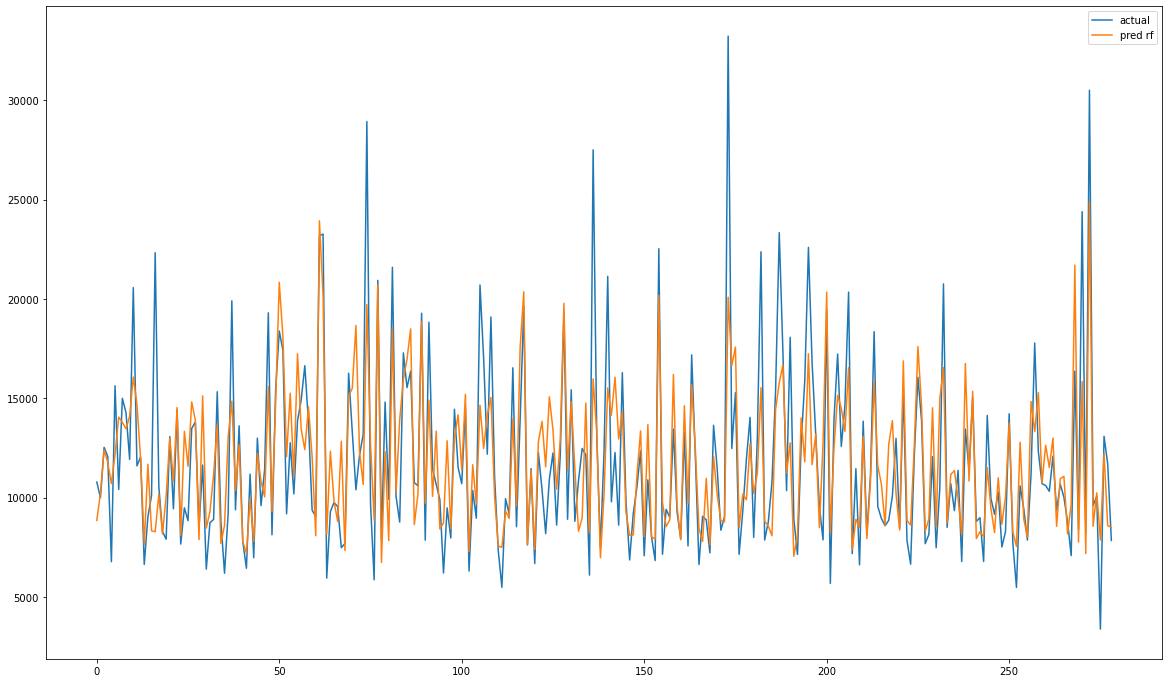

In [106]:
y_pred = model.predict(X_part_test)
print(model)
print("\tExplained variance:", explained_variance_score(y_part_test, y_pred))
print('\tMean Absolute Error (MAE):', metrics.mean_absolute_error(y_part_test, y_pred))
print('\tMean Squared Error (MSE):', metrics.mean_squared_error(y_part_test, y_pred))
print('\tRoot Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_part_test, y_pred)))
print('\tMean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_part_test, y_pred))
print('\tR Squared (R2):', metrics.r2_score(y_part_test, y_pred))
plt.plot(y_part_test.reset_index(drop=True), label = 'actual')
plt.plot(y_pred, label = 'pred rf')

plt.legend()

#### 2. Ondernemingen

In [88]:
# Ondernemingen
x_ondernemingen = df_totaal_events_weather.drop(
          ['Datum', 'Binnengekomen bij Provider',
                     'Doorgeleid naar keuzemenu',
                'Door beller opgehangen in menu',
                 'Automatisch behandeld in menu',
                                          'Jaar', 
                    ('Doorverbindingen', 'AUTO'),
              ('Doorverbindingen', 'BUITENLAND'),
                  ('Doorverbindingen', 'DOUANE'),
           ('Doorverbindingen', 'INTERMEDIAIRS'),
           ('Doorverbindingen', 'ONDERNEMINGEN'),
               ('Doorverbindingen', 'ONTBREEKT'),
                  ('Doorverbindingen', 'OVERIG'),
           ('Doorverbindingen', 'PARTICULIEREN'),
               ('Doorverbindingen', 'TOESLAGEN'),
                  ('Doorverbindingen', 'TOTAAL'),
                            ('Wachtrij', 'AUTO'),
                      ('Wachtrij', 'BUITENLAND'),
                   ('Wachtrij', 'INTERMEDIAIRS'),
                   ('Wachtrij', 'ONDERNEMINGEN'),
                       ('Wachtrij', 'ONTBREEKT'),
                          ('Wachtrij', 'OVERIG'),
                   ('Wachtrij', 'PARTICULIEREN'),
                       ('Wachtrij', 'TOESLAGEN'),
                          ('Wachtrij', 'TOTAAL'),
                 ('Wachtrij_opgehangen', 'AUTO'),
           ('Wachtrij_opgehangen', 'BUITENLAND'),
        ('Wachtrij_opgehangen', 'INTERMEDIAIRS'),
        ('Wachtrij_opgehangen', 'ONDERNEMINGEN'),
            ('Wachtrij_opgehangen', 'ONTBREEKT'),
               ('Wachtrij_opgehangen', 'OVERIG'),
        ('Wachtrij_opgehangen', 'PARTICULIEREN'),
            ('Wachtrij_opgehangen', 'TOESLAGEN'),
               ('Wachtrij_opgehangen', 'TOTAAL'),
                            ('Geholpen', 'AUTO'),
                      ('Geholpen', 'BUITENLAND'),
                   ('Geholpen', 'INTERMEDIAIRS'),
                   ('Geholpen', 'ONDERNEMINGEN'),
                       ('Geholpen', 'ONTBREEKT'),
                          ('Geholpen', 'OVERIG'),
                   ('Geholpen', 'PARTICULIEREN'),
                       ('Geholpen', 'TOESLAGEN'),
                          ('Geholpen', 'TOTAAL'),
                ('Gemiddelde_wachttijd', 'AUTO'),
          ('Gemiddelde_wachttijd', 'BUITENLAND'),
       ('Gemiddelde_wachttijd', 'INTERMEDIAIRS'),
       ('Gemiddelde_wachttijd', 'ONDERNEMINGEN'),
           ('Gemiddelde_wachttijd', 'ONTBREEKT'),
              ('Gemiddelde_wachttijd', 'OVERIG'),
       ('Gemiddelde_wachttijd', 'PARTICULIEREN'),
           ('Gemiddelde_wachttijd', 'TOESLAGEN'),
              ('Gemiddelde_wachttijd', 'TOTAAL'),
                                'UitbetalingVA',
                          'UitbetalingToeslagen',
                 'ComplexityScore_ondernemingen', 
                 'ComplexityScore_particulieren',
                    'ComplexityScore_buitenland', 
                        'ComplexityScore_overig',
                 'ComplexityScore_intermediairs',
                     'ComplexityScore_toeslagen',
                          'ComplexityScore_auto',
                #                   'Prinsjesdag',
                #                'Schoolvakantie',
                #             'WerkdagNaFeestdag',
                #        'DeadlineOmzetbelasting',
                    'DeadlineInkomstenbelasting',
                #         'DeadlineLoonbelasting',
                #'DeadlineVennootschapsbelasting',
                'IncassoMotorrijtuigenbelasting',
                #                      'min_temp',
                #                      'max_temp',
                #                       'zonuren',
                #                     'regenduur'
          ], axis = 1)
y_ondernemingen = df_totaal_events_weather[('Doorverbindingen', 'ONDERNEMINGEN')]

In [142]:
X_ond_train, X_ond_test, y_ond_train, y_ond_test = train_test_split(x_ondernemingen, y_ondernemingen, test_size=0.3, random_state=42, shuffle = True)
for model in regressors[:]:
    model.fit(X_ond_train, y_ond_train)
    y_pred = model.predict(X_ond_test)
    print(model)
    print("\tExplained variance:", explained_variance_score(y_ond_test, y_pred))
    print('\tMean Absolute Error (MAE):', metrics.mean_absolute_error(y_ond_test, y_pred))
    print('\tMean Squared Error (MSE):', metrics.mean_squared_error(y_ond_test, y_pred))
    print('\tRoot Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_ond_test, y_pred)))
    print('\tMean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_ond_test, y_pred))
    print('\tR Squared (R2):', metrics.r2_score(y_ond_test, y_pred))

GradientBoostingRegressor()
	Explained variance: 0.16398579520380052
	Mean Absolute Error (MAE): 1308.2324319205613
	Mean Squared Error (MSE): 4021216.831454995
	Root Mean Squared Error (RMSE): 2005.2971928008565
	Mean Absolute Percentage Error (MAPE): 0.17474738063863704
	R Squared (R2): 0.1567096095002426
RandomForestRegressor()
	Explained variance: 0.3330147525445162
	Mean Absolute Error (MAE): 1203.9210394265233
	Mean Squared Error (MSE): 3205699.583238351
	Root Mean Squared Error (RMSE): 1790.4467552089761
	Mean Absolute Percentage Error (MAPE): 0.1641384294457131
	R Squared (R2): 0.3277319362070231
SVR()
	Explained variance: 0.0014657315312209818
	Mean Absolute Error (MAE): 1606.1942862061899
	Mean Squared Error (MSE): 5084685.492012814
	Root Mean Squared Error (RMSE): 2254.924719810578
	Mean Absolute Percentage Error (MAPE): 0.20686767102088224
	R Squared (R2): -0.06631067009049119


In [143]:
grid = GridSearchCV(RandomForestRegressor(),parameters)
model = grid.fit(X_ond_train,y_ond_train)
print(model.best_params_,'\n')
print(model.best_estimator_,'\n')

{'max_depth': 15, 'n_estimators': 200} 

RandomForestRegressor(max_depth=15, n_estimators=200) 



GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 5, 9, 10, 12, 15],
                         'n_estimators': [200, 500, 1000, 1500, 1750, 2000]})
	Explained variance: 0.28300650478556977
	Mean Absolute Error (MAE): 1242.0041652672123
	Mean Squared Error (MSE): 3464624.9919890477
	Root Mean Squared Error (RMSE): 1861.3503141507372
	Mean Absolute Percentage Error (MAPE): 0.1685026841111165
	R Squared (R2): 0.27343262378305744


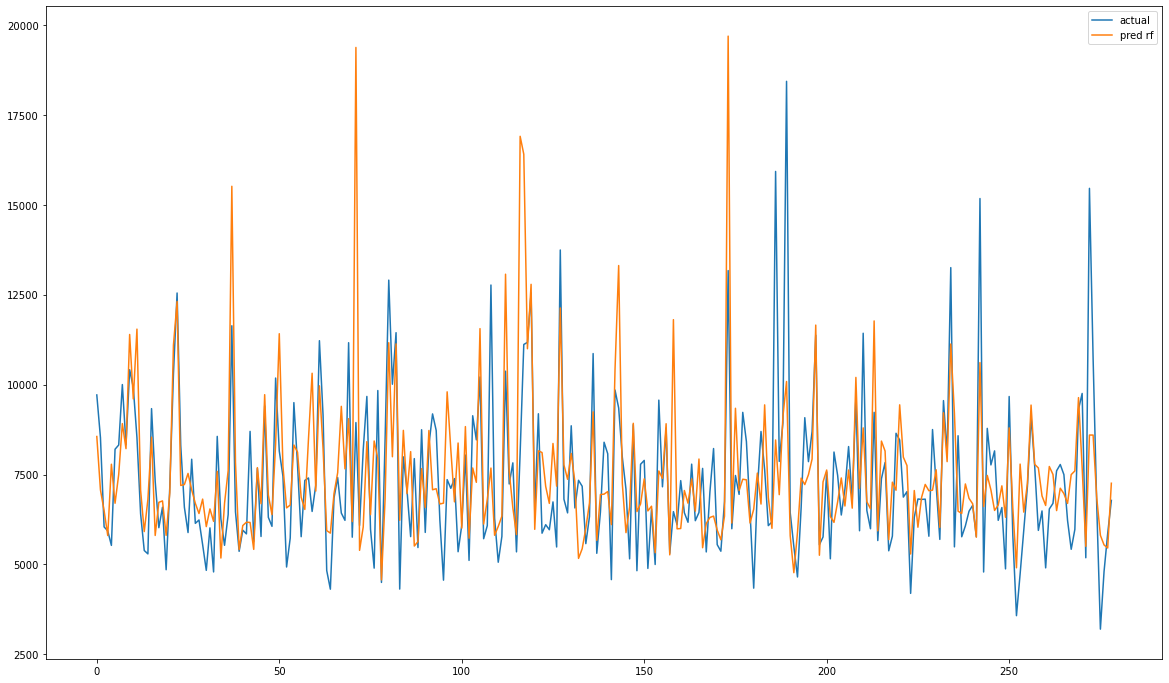

In [144]:
y_pred = model.predict(X_ond_test)
print(model)
print("\tExplained variance:", explained_variance_score(y_ond_test, y_pred))
print('\tMean Absolute Error (MAE):', metrics.mean_absolute_error(y_ond_test, y_pred))
print('\tMean Squared Error (MSE):', metrics.mean_squared_error(y_ond_test, y_pred))
print('\tRoot Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_ond_test, y_pred)))
print('\tMean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_ond_test, y_pred))
print('\tR Squared (R2):', metrics.r2_score(y_ond_test, y_pred))
plt.plot(y_ond_test.reset_index(drop=True), label = 'actual')
plt.plot(y_pred, label = 'pred rf')

plt.legend()

#### 3. Intermediairs

In [89]:
# Intermediars

x_intermediairs = df_totaal_events_weather.drop(
          ['Datum', 'Binnengekomen bij Provider',
                     'Doorgeleid naar keuzemenu',
                'Door beller opgehangen in menu',
                 'Automatisch behandeld in menu',
                                          'Jaar', 
                    ('Doorverbindingen', 'AUTO'),
              ('Doorverbindingen', 'BUITENLAND'),
                  ('Doorverbindingen', 'DOUANE'),
           ('Doorverbindingen', 'INTERMEDIAIRS'),
           ('Doorverbindingen', 'ONDERNEMINGEN'),
               ('Doorverbindingen', 'ONTBREEKT'),
                  ('Doorverbindingen', 'OVERIG'),
           ('Doorverbindingen', 'PARTICULIEREN'),
               ('Doorverbindingen', 'TOESLAGEN'),
                  ('Doorverbindingen', 'TOTAAL'),
                            ('Wachtrij', 'AUTO'),
                      ('Wachtrij', 'BUITENLAND'),
                   ('Wachtrij', 'INTERMEDIAIRS'),
                   ('Wachtrij', 'ONDERNEMINGEN'),
                       ('Wachtrij', 'ONTBREEKT'),
                          ('Wachtrij', 'OVERIG'),
                   ('Wachtrij', 'PARTICULIEREN'),
                       ('Wachtrij', 'TOESLAGEN'),
                          ('Wachtrij', 'TOTAAL'),
                 ('Wachtrij_opgehangen', 'AUTO'),
           ('Wachtrij_opgehangen', 'BUITENLAND'),
        ('Wachtrij_opgehangen', 'INTERMEDIAIRS'),
        ('Wachtrij_opgehangen', 'ONDERNEMINGEN'),
            ('Wachtrij_opgehangen', 'ONTBREEKT'),
               ('Wachtrij_opgehangen', 'OVERIG'),
        ('Wachtrij_opgehangen', 'PARTICULIEREN'),
            ('Wachtrij_opgehangen', 'TOESLAGEN'),
               ('Wachtrij_opgehangen', 'TOTAAL'),
                            ('Geholpen', 'AUTO'),
                      ('Geholpen', 'BUITENLAND'),
                   ('Geholpen', 'INTERMEDIAIRS'),
                   ('Geholpen', 'ONDERNEMINGEN'),
                       ('Geholpen', 'ONTBREEKT'),
                          ('Geholpen', 'OVERIG'),
                   ('Geholpen', 'PARTICULIEREN'),
                       ('Geholpen', 'TOESLAGEN'),
                          ('Geholpen', 'TOTAAL'),
                ('Gemiddelde_wachttijd', 'AUTO'),
          ('Gemiddelde_wachttijd', 'BUITENLAND'),
       ('Gemiddelde_wachttijd', 'INTERMEDIAIRS'),
       ('Gemiddelde_wachttijd', 'ONDERNEMINGEN'),
           ('Gemiddelde_wachttijd', 'ONTBREEKT'),
              ('Gemiddelde_wachttijd', 'OVERIG'),
       ('Gemiddelde_wachttijd', 'PARTICULIEREN'),
           ('Gemiddelde_wachttijd', 'TOESLAGEN'),
              ('Gemiddelde_wachttijd', 'TOTAAL'),
           #                     'UitbetalingVA', 
           #               'UitbetalingToeslagen',
                 'ComplexityScore_particulieren',
                    'ComplexityScore_buitenland', 
                        'ComplexityScore_overig',
                  'ComplexityScore_ondernemingen',
                     'ComplexityScore_toeslagen',
                          'ComplexityScore_auto'
                #                   'Prinsjesdag',
                #                'Schoolvakantie',
                #             'WerkdagNaFeestdag',
                #        'DeadlineOmzetbelasting',
                #    'DeadlineInkomstenbelasting',
                #         'DeadlineLoonbelasting',
                #'DeadlineVennootschapsbelasting',
                #'IncassoMotorrijtuigenbelasting',
                #                      'min_temp',
                #                      'max_temp',
                #                       'zonuren',
                #                     'regenduur'
          ], axis = 1)
y_intermediairs = df_totaal_events_weather[('Doorverbindingen', 'INTERMEDIAIRS')]

In [146]:
X_int_train, X_int_test, y_int_train, y_int_test = train_test_split(x_intermediairs, y_intermediairs, test_size=0.3, random_state=42, shuffle = True)
for model in regressors[:]:
    model.fit(X_int_train, y_int_train)
    y_pred = model.predict(X_int_test)
    print(model)
    print("\tExplained variance:", explained_variance_score(y_int_test, y_pred))
    print('\tMean Absolute Error (MAE):', metrics.mean_absolute_error(y_int_test, y_pred))
    print('\tMean Squared Error (MSE):', metrics.mean_squared_error(y_int_test, y_pred))
    print('\tRoot Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_int_test, y_pred)))
    print('\tMean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_int_test, y_pred))
    print('\tR Squared (R2):', metrics.r2_score(y_int_test, y_pred))

GradientBoostingRegressor()
	Explained variance: 0.7432997533361003
	Mean Absolute Error (MAE): 298.8226731916616
	Mean Squared Error (MSE): 145836.16930032065
	Root Mean Squared Error (RMSE): 381.8850210473313
	Mean Absolute Percentage Error (MAPE): 0.0893770210137397
	R Squared (R2): 0.742536799326986
RandomForestRegressor()
	Explained variance: 0.7019801192287116
	Mean Absolute Error (MAE): 318.98663082437275
	Mean Squared Error (MSE): 168836.62017025088
	Root Mean Squared Error (RMSE): 410.8973353165616
	Mean Absolute Percentage Error (MAPE): 0.10119149651252024
	R Squared (R2): 0.7019311681841388
SVR()
	Explained variance: 0.016237960140786156
	Mean Absolute Error (MAE): 577.8976215695957
	Mean Squared Error (MSE): 561074.9246067272
	Root Mean Squared Error (RMSE): 749.0493472440432
	Mean Absolute Percentage Error (MAPE): 0.18462225676710228
	R Squared (R2): 0.00946283353658861


In [147]:
grid = GridSearchCV(GradientBoostingRegressor(),parameters)
model = grid.fit(X_int_train,y_int_train)
print(model.best_params_,'\n')
print(model.best_estimator_,'\n')

{'max_depth': 3, 'n_estimators': 200} 

GradientBoostingRegressor(n_estimators=200) 



GridSearchCV(estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [3, 5, 9, 10, 12, 15],
                         'n_estimators': [200, 500, 1000, 1500, 1750, 2000]})
	Explained variance: 0.7413000259096206
	Mean Absolute Error (MAE): 301.3130284472884
	Mean Squared Error (MSE): 146741.7910545433
	Root Mean Squared Error (RMSE): 383.0689116262808
	Mean Absolute Percentage Error (MAPE): 0.09008668394025653
	R Squared (R2): 0.7409379896725641


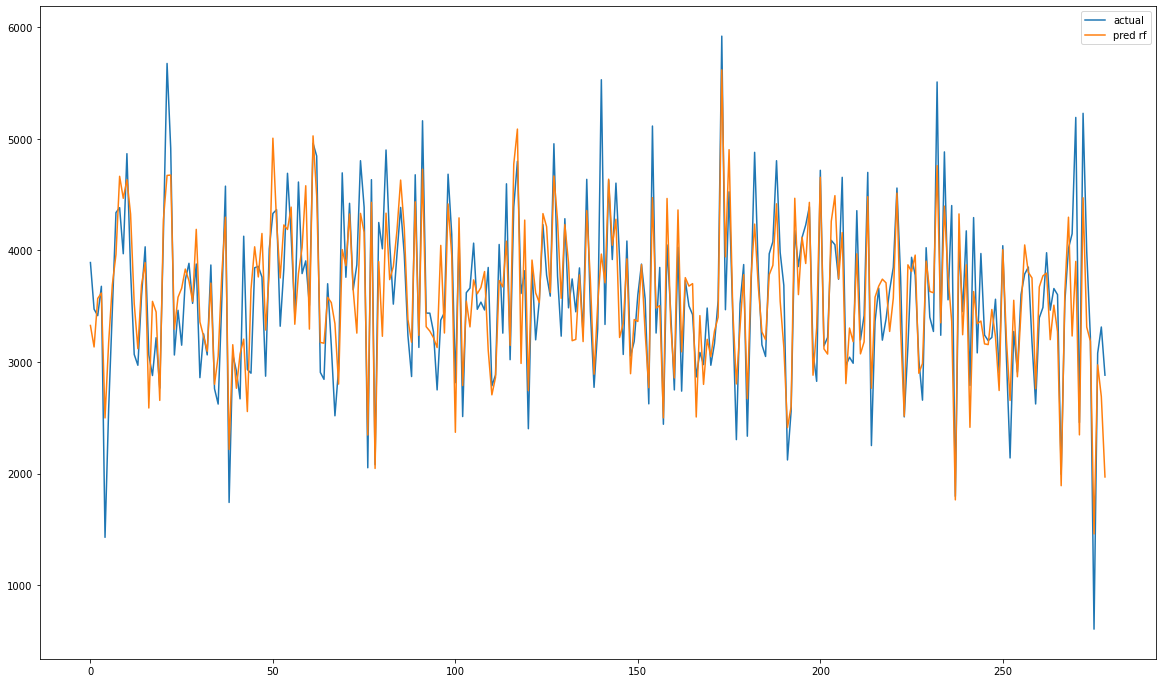

In [148]:
y_pred = model.predict(X_int_test)
print(model)
print("\tExplained variance:", explained_variance_score(y_int_test, y_pred))
print('\tMean Absolute Error (MAE):', metrics.mean_absolute_error(y_int_test, y_pred))
print('\tMean Squared Error (MSE):', metrics.mean_squared_error(y_int_test, y_pred))
print('\tRoot Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_int_test, y_pred)))
print('\tMean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_int_test, y_pred))
print('\tR Squared (R2):', metrics.r2_score(y_int_test, y_pred))
plt.plot(y_int_test.reset_index(drop=True), label = 'actual')
plt.plot(y_pred, label = 'pred rf')

plt.legend()

#### 4. Toeslagen

In [90]:
# Toeslagen

x_toeslagen = df_totaal_events_weather.drop([
                                       'Datum',
                    'Binnengekomen bij Provider',
                     'Doorgeleid naar keuzemenu',
                'Door beller opgehangen in menu',
                 'Automatisch behandeld in menu',
                    ('Doorverbindingen', 'AUTO'),
              ('Doorverbindingen', 'BUITENLAND'),
                  ('Doorverbindingen', 'DOUANE'),
           ('Doorverbindingen', 'INTERMEDIAIRS'),
           ('Doorverbindingen', 'ONDERNEMINGEN'),
               ('Doorverbindingen', 'ONTBREEKT'),
                  ('Doorverbindingen', 'OVERIG'),
           ('Doorverbindingen', 'PARTICULIEREN'),
               ('Doorverbindingen', 'TOESLAGEN'),
                  ('Doorverbindingen', 'TOTAAL'),
                            ('Wachtrij', 'AUTO'),
                      ('Wachtrij', 'BUITENLAND'),
                   ('Wachtrij', 'INTERMEDIAIRS'),
                   ('Wachtrij', 'ONDERNEMINGEN'),
                       ('Wachtrij', 'ONTBREEKT'),
                          ('Wachtrij', 'OVERIG'),
                   ('Wachtrij', 'PARTICULIEREN'),
                       ('Wachtrij', 'TOESLAGEN'),
                          ('Wachtrij', 'TOTAAL'),
                 ('Wachtrij_opgehangen', 'AUTO'),
           ('Wachtrij_opgehangen', 'BUITENLAND'),
        ('Wachtrij_opgehangen', 'INTERMEDIAIRS'),
        ('Wachtrij_opgehangen', 'ONDERNEMINGEN'),
            ('Wachtrij_opgehangen', 'ONTBREEKT'),
               ('Wachtrij_opgehangen', 'OVERIG'),
        ('Wachtrij_opgehangen', 'PARTICULIEREN'),
            ('Wachtrij_opgehangen', 'TOESLAGEN'),
               ('Wachtrij_opgehangen', 'TOTAAL'),
                            ('Geholpen', 'AUTO'),
                      ('Geholpen', 'BUITENLAND'),
                   ('Geholpen', 'INTERMEDIAIRS'),
                   ('Geholpen', 'ONDERNEMINGEN'),
                       ('Geholpen', 'ONTBREEKT'),
                          ('Geholpen', 'OVERIG'),
                   ('Geholpen', 'PARTICULIEREN'),
                       ('Geholpen', 'TOESLAGEN'),
                          ('Geholpen', 'TOTAAL'),
                ('Gemiddelde_wachttijd', 'AUTO'),
          ('Gemiddelde_wachttijd', 'BUITENLAND'),
       ('Gemiddelde_wachttijd', 'INTERMEDIAIRS'),
       ('Gemiddelde_wachttijd', 'ONDERNEMINGEN'),
           ('Gemiddelde_wachttijd', 'ONTBREEKT'),
              ('Gemiddelde_wachttijd', 'OVERIG'),
       ('Gemiddelde_wachttijd', 'PARTICULIEREN'),
           ('Gemiddelde_wachttijd', 'TOESLAGEN'),
              ('Gemiddelde_wachttijd', 'TOTAAL'),
                                          'Jaar',
                 'ComplexityScore_ondernemingen',
                 'ComplexityScore_particulieren',
                    'ComplexityScore_buitenland',
                        'ComplexityScore_overig',
                 'ComplexityScore_intermediairs',
                     'ComplexityScore_toeslagen',
                          'ComplexityScore_auto',
                                'UitbetalingVA',
                #          'UitbetalingToeslagen',
                #                   'Prinsjesdag',
                #                'Schoolvakantie',
                #             'WerkdagNaFeestdag',
                        'DeadlineOmzetbelasting',
                    'DeadlineInkomstenbelasting',
                         'DeadlineLoonbelasting',
                'DeadlineVennootschapsbelasting',
                'IncassoMotorrijtuigenbelasting',
                #                      'min_temp',
                #                      'max_temp',
                #                       'zonuren',
                #                     'regenduur'
          ], axis = 1)
y_toeslagen = df_totaal_events_weather[('Doorverbindingen', 'TOESLAGEN')]

In [150]:
X_toeslag_train, X_toeslag_test, y_toeslag_train, y_toeslag_test = train_test_split(x_toeslagen, y_toeslagen, test_size=0.3, random_state=42, shuffle = True)
for model in regressors[:]:
    model.fit(X_toeslag_train, y_toeslag_train)
    y_pred = model.predict(X_toeslag_test)
    print(model)
    print("\tExplained variance:", explained_variance_score(y_toeslag_test, y_pred))
    print('\tMean Absolute Error (MAE):', metrics.mean_absolute_error(y_toeslag_test, y_pred))
    print('\tMean Squared Error (MSE):', metrics.mean_squared_error(y_toeslag_test, y_pred))
    print('\tRoot Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_toeslag_test, y_pred)))
    print('\tMean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_toeslag_test, y_pred))
    print('\tR Squared (R2):', metrics.r2_score(y_toeslag_test, y_pred))

GradientBoostingRegressor()
	Explained variance: 0.33120813036332664
	Mean Absolute Error (MAE): 1918.0652911424825
	Mean Squared Error (MSE): 8254152.849249009
	Root Mean Squared Error (RMSE): 2873.0041505798436
	Mean Absolute Percentage Error (MAPE): 0.21726363286233757
	R Squared (R2): 0.32933033188219285
RandomForestRegressor()
	Explained variance: 0.41594239884757767
	Mean Absolute Error (MAE): 1832.473512544803
	Mean Squared Error (MSE): 7203375.131332975
	Root Mean Squared Error (RMSE): 2683.910417903879
	Mean Absolute Percentage Error (MAPE): 0.20014753697696094
	R Squared (R2): 0.41470853558294585
SVR()
	Explained variance: 0.0006007574405982874
	Mean Absolute Error (MAE): 2223.480228858486
	Mean Squared Error (MSE): 12560549.468615526
	Root Mean Squared Error (RMSE): 3544.0865492557496
	Mean Absolute Percentage Error (MAPE): 0.23252300353808436
	R Squared (R2): -0.02057469704599879


In [151]:
grid = GridSearchCV(RandomForestRegressor(),parameters)
model = grid.fit(X_toeslag_train,y_toeslag_train)
print(model.best_params_,'\n')
print(model.best_estimator_,'\n')

{'max_depth': 15, 'n_estimators': 1500} 

RandomForestRegressor(max_depth=15, n_estimators=1500) 



GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 5, 9, 10, 12, 15],
                         'n_estimators': [200, 500, 1000, 1500, 1750, 2000]})
	Explained variance: 0.39402651253596144
	Mean Absolute Error (MAE): 1859.7919802275383
	Mean Squared Error (MSE): 7489736.420142614
	Root Mean Squared Error (RMSE): 2736.738281265239
	Mean Absolute Percentage Error (MAPE): 0.20472129475877765
	R Squared (R2): 0.3914409957111562


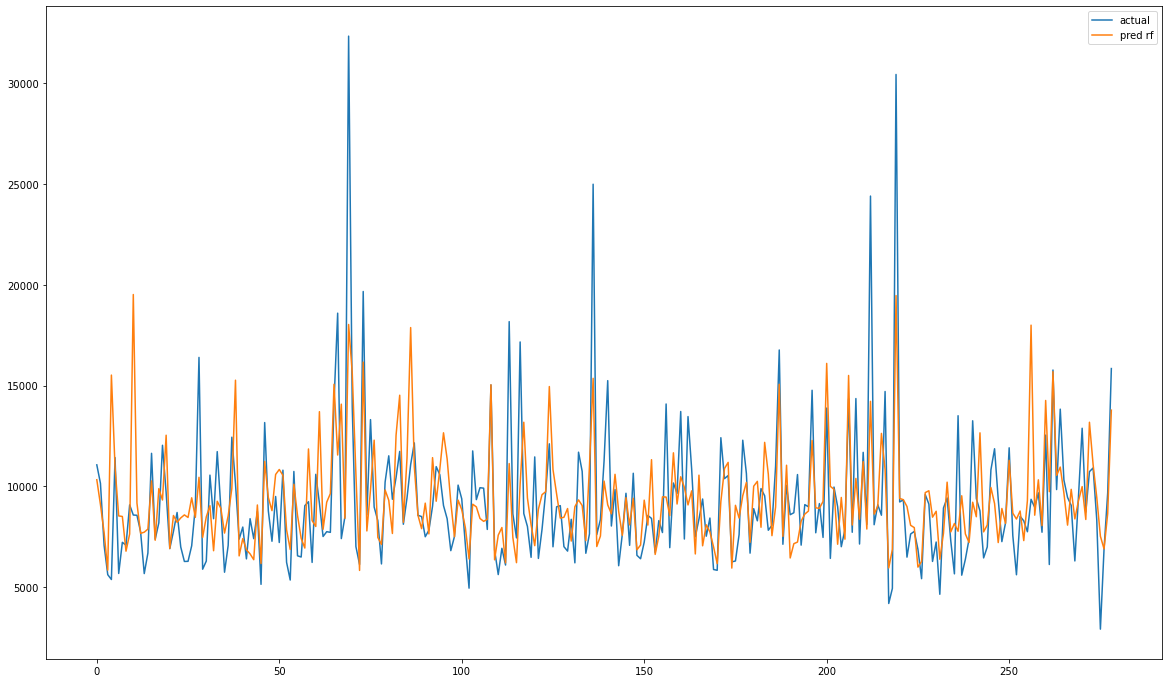

In [152]:
y_pred = model.predict(X_toeslag_test)
print(model)
print("\tExplained variance:", explained_variance_score(y_toeslag_test, y_pred))
print('\tMean Absolute Error (MAE):', metrics.mean_absolute_error(y_toeslag_test, y_pred))
print('\tMean Squared Error (MSE):', metrics.mean_squared_error(y_toeslag_test, y_pred))
print('\tRoot Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_toeslag_test, y_pred)))
print('\tMean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_toeslag_test, y_pred))
print('\tR Squared (R2):', metrics.r2_score(y_toeslag_test, y_pred))
plt.plot(y_toeslag_test.reset_index(drop=True), label = 'actual')
plt.plot(y_pred, label = 'pred rf')

plt.legend()

#### 5. Auto

In [91]:
# AUTO

x_auto = df_totaal_events_weather.drop([
                                       'Datum',
                                 'UitbetalingVA',
                          'UitbetalingToeslagen',
                    'Binnengekomen bij Provider',
                     'Doorgeleid naar keuzemenu',
                'Door beller opgehangen in menu',
                 'Automatisch behandeld in menu',
                    ('Doorverbindingen', 'AUTO'),
              ('Doorverbindingen', 'BUITENLAND'),
                  ('Doorverbindingen', 'DOUANE'),
           ('Doorverbindingen', 'INTERMEDIAIRS'),
           ('Doorverbindingen', 'ONDERNEMINGEN'),
               ('Doorverbindingen', 'ONTBREEKT'),
                  ('Doorverbindingen', 'OVERIG'),
           ('Doorverbindingen', 'PARTICULIEREN'),
               ('Doorverbindingen', 'TOESLAGEN'),
                  ('Doorverbindingen', 'TOTAAL'),
                            ('Wachtrij', 'AUTO'),
                      ('Wachtrij', 'BUITENLAND'),
                   ('Wachtrij', 'INTERMEDIAIRS'),
                   ('Wachtrij', 'ONDERNEMINGEN'),
                       ('Wachtrij', 'ONTBREEKT'),
                          ('Wachtrij', 'OVERIG'),
                   ('Wachtrij', 'PARTICULIEREN'),
                       ('Wachtrij', 'TOESLAGEN'),
                          ('Wachtrij', 'TOTAAL'),
                 ('Wachtrij_opgehangen', 'AUTO'),
           ('Wachtrij_opgehangen', 'BUITENLAND'),
        ('Wachtrij_opgehangen', 'INTERMEDIAIRS'),
        ('Wachtrij_opgehangen', 'ONDERNEMINGEN'),
            ('Wachtrij_opgehangen', 'ONTBREEKT'),
               ('Wachtrij_opgehangen', 'OVERIG'),
        ('Wachtrij_opgehangen', 'PARTICULIEREN'),
            ('Wachtrij_opgehangen', 'TOESLAGEN'),
               ('Wachtrij_opgehangen', 'TOTAAL'),
                            ('Geholpen', 'AUTO'),
                      ('Geholpen', 'BUITENLAND'),
                   ('Geholpen', 'INTERMEDIAIRS'),
                   ('Geholpen', 'ONDERNEMINGEN'),
                       ('Geholpen', 'ONTBREEKT'),
                          ('Geholpen', 'OVERIG'),
                   ('Geholpen', 'PARTICULIEREN'),
                       ('Geholpen', 'TOESLAGEN'),
                          ('Geholpen', 'TOTAAL'),
                ('Gemiddelde_wachttijd', 'AUTO'),
          ('Gemiddelde_wachttijd', 'BUITENLAND'),
       ('Gemiddelde_wachttijd', 'INTERMEDIAIRS'),
       ('Gemiddelde_wachttijd', 'ONDERNEMINGEN'),
           ('Gemiddelde_wachttijd', 'ONTBREEKT'),
              ('Gemiddelde_wachttijd', 'OVERIG'),
       ('Gemiddelde_wachttijd', 'PARTICULIEREN'),
           ('Gemiddelde_wachttijd', 'TOESLAGEN'),
              ('Gemiddelde_wachttijd', 'TOTAAL'),
                                          'Jaar',
                 'ComplexityScore_ondernemingen',
                 'ComplexityScore_particulieren',
                    'ComplexityScore_buitenland',
                        'ComplexityScore_overig',
                 'ComplexityScore_intermediairs',
                     'ComplexityScore_toeslagen',
                          'ComplexityScore_auto',
                                 'UitbetalingVA',
                          'UitbetalingToeslagen',
                                    'Prinsjesdag',
               #                  'Schoolvakantie',
               #               'WerkdagNaFeestdag',
                          'DeadlineOmzetbelasting',
                      'DeadlineInkomstenbelasting',
                           'DeadlineLoonbelasting',
                 'DeadlineVennootschapsbelasting',
               #   'IncassoMotorrijtuigenbelasting',
               #                       'min_temp',
               #                       'max_temp',
               #                        'zonuren',
               #                      'regenduur'
                                          ], axis = 1)
y_auto = df_totaal_events_weather[('Doorverbindingen', 'AUTO')]

In [154]:
X_auto_train, X_auto_test, y_auto_train, y_auto_test = train_test_split(x_auto, y_auto, test_size=0.3, random_state=42, shuffle = True)
for model in regressors[:]:
    model.fit(X_auto_train, y_auto_train)
    y_pred = model.predict(X_auto_test)
    print(model)
    print("\tExplained variance:", explained_variance_score(y_auto_test, y_pred))
    print('\tMean Absolute Error (MAE):', metrics.mean_absolute_error(y_auto_test, y_pred))
    print('\tMean Squared Error (MSE):', metrics.mean_squared_error(y_auto_test, y_pred))
    print('\tRoot Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_auto_test, y_pred)))
    print('\tMean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_auto_test, y_pred))
    print('\tR Squared (R2):', metrics.r2_score(y_auto_test, y_pred))

GradientBoostingRegressor()
	Explained variance: 0.4444605128228575
	Mean Absolute Error (MAE): 418.5124388486784
	Mean Squared Error (MSE): 264548.3709903105
	Root Mean Squared Error (RMSE): 514.3426591196869
	Mean Absolute Percentage Error (MAPE): 0.1266395127090595
	R Squared (R2): 0.4435777443443739
RandomForestRegressor()
	Explained variance: 0.34476089854413505
	Mean Absolute Error (MAE): 446.8697132616487
	Mean Squared Error (MSE): 313632.37271218636
	Root Mean Squared Error (RMSE): 560.0289034614074
	Mean Absolute Percentage Error (MAPE): 0.13514688737536645
	R Squared (R2): 0.34033979639386036
SVR()
	Explained variance: 0.02193831585101713
	Mean Absolute Error (MAE): 535.196421753314
	Mean Squared Error (MSE): 483475.32080946345
	Root Mean Squared Error (RMSE): 695.3238963313885
	Mean Absolute Percentage Error (MAPE): 0.15783227456638807
	R Squared (R2): -0.016889378496616203


In [155]:
grid = GridSearchCV(GradientBoostingRegressor(),parameters)
model = grid.fit(X_auto_train,y_auto_train)
print(model.best_params_,'\n')
print(model.best_estimator_,'\n')

{'max_depth': 3, 'n_estimators': 200} 

GradientBoostingRegressor(n_estimators=200) 



GridSearchCV(estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [3, 5, 9, 10, 12, 15],
                         'n_estimators': [200, 500, 1000, 1500, 1750, 2000]})
	Explained variance: 0.4320793420711043
	Mean Absolute Error (MAE): 422.7277517610208
	Mean Squared Error (MSE): 270257.8369129174
	Root Mean Squared Error (RMSE): 519.8632867523128
	Mean Absolute Percentage Error (MAPE): 0.12736192653109144
	R Squared (R2): 0.431569075021053


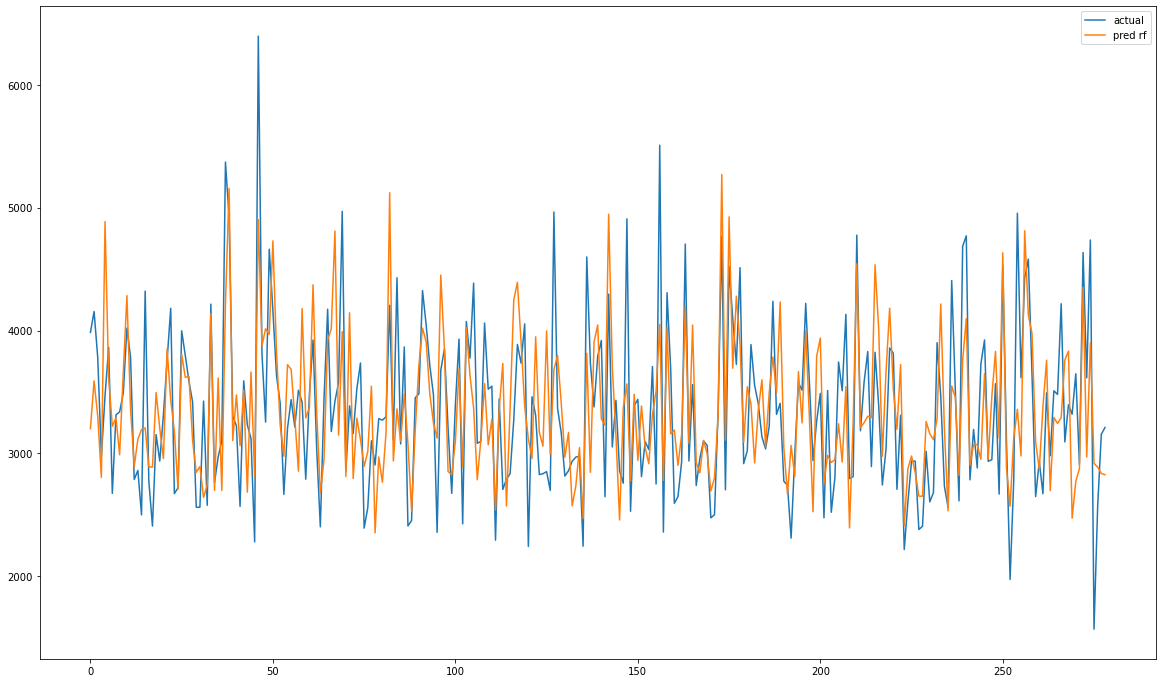

In [156]:
y_pred = model.predict(X_auto_test)
print(model)
print("\tExplained variance:", explained_variance_score(y_auto_test, y_pred))
print('\tMean Absolute Error (MAE):', metrics.mean_absolute_error(y_auto_test, y_pred))
print('\tMean Squared Error (MSE):', metrics.mean_squared_error(y_auto_test, y_pred))
print('\tRoot Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_auto_test, y_pred)))
print('\tMean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_auto_test, y_pred))
print('\tR Squared (R2):', metrics.r2_score(y_auto_test, y_pred))
plt.plot(y_auto_test.reset_index(drop=True), label = 'actual')
plt.plot(y_pred, label = 'pred rf')

plt.legend()

#### 6. Buitenland

In [92]:
# BUITENLAND

x_buitenland = df_totaal_events_weather.drop([
                                       'Datum',
                                 'UitbetalingVA',
                          'UitbetalingToeslagen',
                    'Binnengekomen bij Provider',
                     'Doorgeleid naar keuzemenu',
                'Door beller opgehangen in menu',
                 'Automatisch behandeld in menu',
                    ('Doorverbindingen', 'AUTO'),
              ('Doorverbindingen', 'BUITENLAND'),
                  ('Doorverbindingen', 'DOUANE'),
           ('Doorverbindingen', 'INTERMEDIAIRS'),
           ('Doorverbindingen', 'ONDERNEMINGEN'),
               ('Doorverbindingen', 'ONTBREEKT'),
                  ('Doorverbindingen', 'OVERIG'),
           ('Doorverbindingen', 'PARTICULIEREN'),
               ('Doorverbindingen', 'TOESLAGEN'),
                  ('Doorverbindingen', 'TOTAAL'),
                            ('Wachtrij', 'AUTO'),
                      ('Wachtrij', 'BUITENLAND'),
                   ('Wachtrij', 'INTERMEDIAIRS'),
                   ('Wachtrij', 'ONDERNEMINGEN'),
                       ('Wachtrij', 'ONTBREEKT'),
                          ('Wachtrij', 'OVERIG'),
                   ('Wachtrij', 'PARTICULIEREN'),
                       ('Wachtrij', 'TOESLAGEN'),
                          ('Wachtrij', 'TOTAAL'),
                 ('Wachtrij_opgehangen', 'AUTO'),
           ('Wachtrij_opgehangen', 'BUITENLAND'),
        ('Wachtrij_opgehangen', 'INTERMEDIAIRS'),
        ('Wachtrij_opgehangen', 'ONDERNEMINGEN'),
            ('Wachtrij_opgehangen', 'ONTBREEKT'),
               ('Wachtrij_opgehangen', 'OVERIG'),
        ('Wachtrij_opgehangen', 'PARTICULIEREN'),
            ('Wachtrij_opgehangen', 'TOESLAGEN'),
               ('Wachtrij_opgehangen', 'TOTAAL'),
                            ('Geholpen', 'AUTO'),
                      ('Geholpen', 'BUITENLAND'),
                   ('Geholpen', 'INTERMEDIAIRS'),
                   ('Geholpen', 'ONDERNEMINGEN'),
                       ('Geholpen', 'ONTBREEKT'),
                          ('Geholpen', 'OVERIG'),
                   ('Geholpen', 'PARTICULIEREN'),
                       ('Geholpen', 'TOESLAGEN'),
                          ('Geholpen', 'TOTAAL'),
                ('Gemiddelde_wachttijd', 'AUTO'),
          ('Gemiddelde_wachttijd', 'BUITENLAND'),
       ('Gemiddelde_wachttijd', 'INTERMEDIAIRS'),
       ('Gemiddelde_wachttijd', 'ONDERNEMINGEN'),
           ('Gemiddelde_wachttijd', 'ONTBREEKT'),
              ('Gemiddelde_wachttijd', 'OVERIG'),
       ('Gemiddelde_wachttijd', 'PARTICULIEREN'),
           ('Gemiddelde_wachttijd', 'TOESLAGEN'),
              ('Gemiddelde_wachttijd', 'TOTAAL'),
                                          'Jaar',
                 'ComplexityScore_ondernemingen',
                 'ComplexityScore_particulieren',
                    'ComplexityScore_buitenland',
                        'ComplexityScore_overig',
                 'ComplexityScore_intermediairs',
                     'ComplexityScore_toeslagen',
                          'ComplexityScore_auto',
                                 'UitbetalingVA',
                          'UitbetalingToeslagen',
               #                     'Prinsjesdag',
               #                  'Schoolvakantie',
               #               'WerkdagNaFeestdag',
                          'DeadlineOmzetbelasting',
               #       'DeadlineInkomstenbelasting',
                           'DeadlineLoonbelasting',
                 'DeadlineVennootschapsbelasting',
                  'IncassoMotorrijtuigenbelasting',
                                 #     'min_temp',
                                 #     'max_temp',
                                #       'zonuren',
                                #     'regenduur'
          ], axis = 1)
y_buitenland = df_totaal_events_weather[('Doorverbindingen', 'BUITENLAND')]

In [93]:
X_bui_train, X_bui_test, y_bui_train, y_bui_test = train_test_split(x_buitenland, y_buitenland, test_size=0.3, random_state=42, shuffle = True)
for model in regressors[:]:
    model.fit(X_bui_train, y_bui_train)
    y_pred = model.predict(X_bui_test)
    print(model)
    print("\tExplained variance:", explained_variance_score(y_bui_test, y_pred))
    print('\tMean Absolute Error (MAE):', metrics.mean_absolute_error(y_bui_test, y_pred))
    print('\tMean Squared Error (MSE):', metrics.mean_squared_error(y_bui_test, y_pred))
    print('\tRoot Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_bui_test, y_pred)))
    print('\tMean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_bui_test, y_pred))
    print('\tR Squared (R2):', metrics.r2_score(y_bui_test, y_pred))

GradientBoostingRegressor()
	Explained variance: 0.49658932599301964
	Mean Absolute Error (MAE): 381.603767579484
	Mean Squared Error (MSE): 225667.38317358587
	Root Mean Squared Error (RMSE): 475.0446117719744
	Mean Absolute Percentage Error (MAPE): 0.13425664518952293
	R Squared (R2): 0.49640052076060404
RandomForestRegressor()
	Explained variance: 0.3744891980345989
	Mean Absolute Error (MAE): 419.6312186379929
	Mean Squared Error (MSE): 280351.85507204296
	Root Mean Squared Error (RMSE): 529.4826296225807
	Mean Absolute Percentage Error (MAPE): 0.1480516397988103
	R Squared (R2): 0.37436661766278234
SVR()
	Explained variance: 0.004493204492274527
	Mean Absolute Error (MAE): 528.1400571846273
	Mean Squared Error (MSE): 468272.643932326
	Root Mean Squared Error (RMSE): 684.3044965016129
	Mean Absolute Percentage Error (MAPE): 0.18353252737930068
	R Squared (R2): -0.04499753712736432


In [94]:
grid = GridSearchCV(GradientBoostingRegressor(),parameters)
model = grid.fit(X_bui_train,y_bui_train)
print(model.best_params_,'\n')
print(model.best_estimator_,'\n')

{'max_depth': 3, 'n_estimators': 200} 

GradientBoostingRegressor(n_estimators=200) 



GridSearchCV(estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [3, 5, 9, 10, 12, 15],
                         'n_estimators': [200, 500, 1000, 1500, 1750, 2000]})
	Explained variance: 0.4899928047732539
	Mean Absolute Error (MAE): 380.16873219806024
	Mean Squared Error (MSE): 228641.33955575514
	Root Mean Squared Error (RMSE): 478.16455280139195
	Mean Absolute Percentage Error (MAPE): 0.13308714747183306
	R Squared (R2): 0.4897638377615855


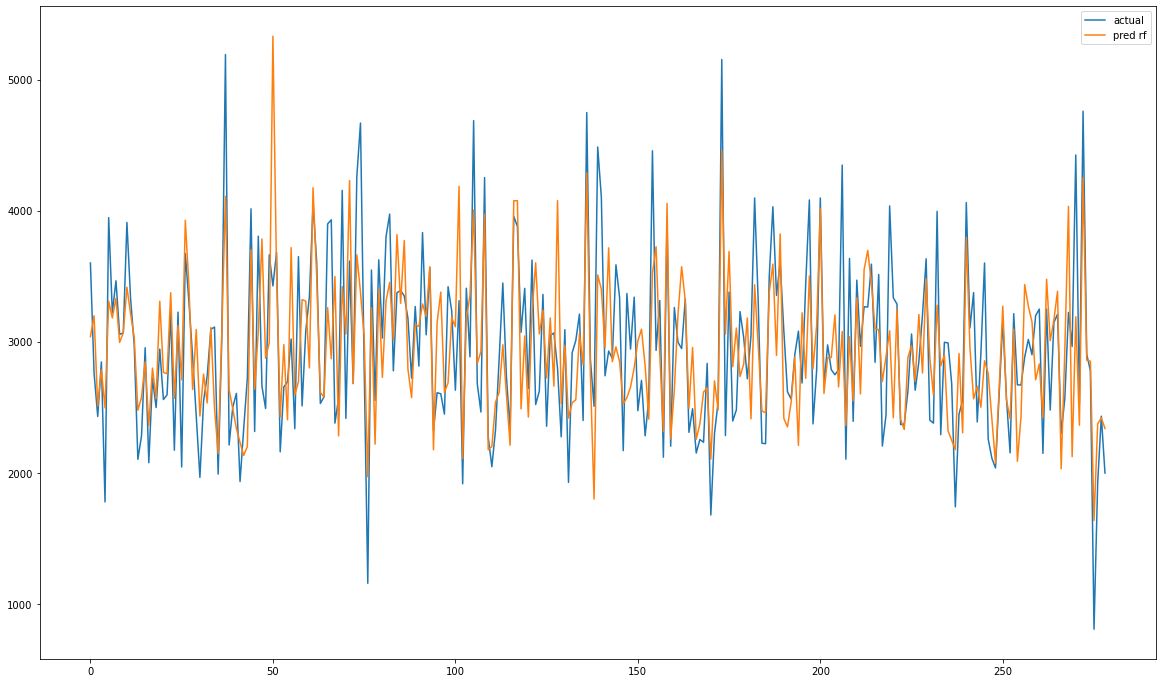

In [95]:
y_pred = model.predict(X_bui_test)
print(model)
print("\tExplained variance:", explained_variance_score(y_bui_test, y_pred))
print('\tMean Absolute Error (MAE):', metrics.mean_absolute_error(y_bui_test, y_pred))
print('\tMean Squared Error (MSE):', metrics.mean_squared_error(y_bui_test, y_pred))
print('\tRoot Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_bui_test, y_pred)))
print('\tMean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_bui_test, y_pred))
print('\tR Squared (R2):', metrics.r2_score(y_bui_test, y_pred))
plt.plot(y_bui_test.reset_index(drop=True), label = 'actual')
plt.plot(y_pred, label = 'pred rf')

plt.legend()

#### 7. Overig

In [161]:
# OVERIG

x_overig = df_totaal_events_weather.drop([
                                       'Datum',
                                 'UitbetalingVA',
                          'UitbetalingToeslagen',
                    'Binnengekomen bij Provider',
                     'Doorgeleid naar keuzemenu',
                'Door beller opgehangen in menu',
                 'Automatisch behandeld in menu',
                    ('Doorverbindingen', 'AUTO'),
              ('Doorverbindingen', 'BUITENLAND'),
                  ('Doorverbindingen', 'DOUANE'),
           ('Doorverbindingen', 'INTERMEDIAIRS'),
           ('Doorverbindingen', 'ONDERNEMINGEN'),
               ('Doorverbindingen', 'ONTBREEKT'),
                  ('Doorverbindingen', 'OVERIG'),
           ('Doorverbindingen', 'PARTICULIEREN'),
               ('Doorverbindingen', 'TOESLAGEN'),
                  ('Doorverbindingen', 'TOTAAL'),
                            ('Wachtrij', 'AUTO'),
                      ('Wachtrij', 'BUITENLAND'),
                   ('Wachtrij', 'INTERMEDIAIRS'),
                   ('Wachtrij', 'ONDERNEMINGEN'),
                       ('Wachtrij', 'ONTBREEKT'),
                          ('Wachtrij', 'OVERIG'),
                   ('Wachtrij', 'PARTICULIEREN'),
                       ('Wachtrij', 'TOESLAGEN'),
                          ('Wachtrij', 'TOTAAL'),
                 ('Wachtrij_opgehangen', 'AUTO'),
           ('Wachtrij_opgehangen', 'BUITENLAND'),
        ('Wachtrij_opgehangen', 'INTERMEDIAIRS'),
        ('Wachtrij_opgehangen', 'ONDERNEMINGEN'),
            ('Wachtrij_opgehangen', 'ONTBREEKT'),
               ('Wachtrij_opgehangen', 'OVERIG'),
        ('Wachtrij_opgehangen', 'PARTICULIEREN'),
            ('Wachtrij_opgehangen', 'TOESLAGEN'),
               ('Wachtrij_opgehangen', 'TOTAAL'),
                            ('Geholpen', 'AUTO'),
                      ('Geholpen', 'BUITENLAND'),
                   ('Geholpen', 'INTERMEDIAIRS'),
                   ('Geholpen', 'ONDERNEMINGEN'),
                       ('Geholpen', 'ONTBREEKT'),
                          ('Geholpen', 'OVERIG'),
                   ('Geholpen', 'PARTICULIEREN'),
                       ('Geholpen', 'TOESLAGEN'),
                          ('Geholpen', 'TOTAAL'),
                ('Gemiddelde_wachttijd', 'AUTO'),
          ('Gemiddelde_wachttijd', 'BUITENLAND'),
       ('Gemiddelde_wachttijd', 'INTERMEDIAIRS'),
       ('Gemiddelde_wachttijd', 'ONDERNEMINGEN'),
           ('Gemiddelde_wachttijd', 'ONTBREEKT'),
              ('Gemiddelde_wachttijd', 'OVERIG'),
       ('Gemiddelde_wachttijd', 'PARTICULIEREN'),
           ('Gemiddelde_wachttijd', 'TOESLAGEN'),
              ('Gemiddelde_wachttijd', 'TOTAAL'),
                                          'Jaar',
                 'ComplexityScore_ondernemingen',
                 'ComplexityScore_particulieren',
                    'ComplexityScore_buitenland',
                        'ComplexityScore_overig',
                 'ComplexityScore_intermediairs',
                     'ComplexityScore_toeslagen',
                          'ComplexityScore_auto',
               #                  'UitbetalingVA',
               #           'UitbetalingToeslagen',
               #                     'Prinsjesdag',
               #                  'Schoolvakantie',
               #               'WerkdagNaFeestdag',
                          'DeadlineOmzetbelasting',
                      'DeadlineInkomstenbelasting',
                           'DeadlineLoonbelasting',
                 'DeadlineVennootschapsbelasting',
                  'IncassoMotorrijtuigenbelasting',
                                      'min_temp',
                                      'max_temp',
                                       'zonuren',
                                     'regenduur'
          ], axis = 1)
y_overig = df_totaal_events_weather[('Doorverbindingen', 'OVERIG')]

In [162]:
X_overig_train, X_overig_test, y_overig_train, y_overig_test = train_test_split(x_overig, y_overig, test_size=0.3, random_state=42, shuffle = True)
for model in regressors[:]:
    model.fit(X_overig_train, y_overig_train)
    y_pred = model.predict(X_overig_test)
    print(model)
    print("\tExplained variance:", explained_variance_score(y_overig_test, y_pred))
    print('\tMean Absolute Error (MAE):', metrics.mean_absolute_error(y_overig_test, y_pred))
    print('\tMean Squared Error (MSE):', metrics.mean_squared_error(y_overig_test, y_pred))
    print('\tRoot Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_overig_test, y_pred)))
    print('\tMean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_overig_test, y_pred))
    print('\tR Squared (R2):', metrics.r2_score(y_overig_test, y_pred))

GradientBoostingRegressor()
	Explained variance: 0.20367731781900433
	Mean Absolute Error (MAE): 765.7932435917722
	Mean Squared Error (MSE): 874116.1231304868
	Root Mean Squared Error (RMSE): 934.9417752622282
	Mean Absolute Percentage Error (MAPE): 0.17565910615498476
	R Squared (R2): 0.20156571364353737
RandomForestRegressor()
	Explained variance: -0.012595896738927026
	Mean Absolute Error (MAE): 844.9414336917562
	Mean Squared Error (MSE): 1110138.4653942653
	Root Mean Squared Error (RMSE): 1053.6310860041408
	Mean Absolute Percentage Error (MAPE): 0.19339053438522952
	R Squared (R2): -0.01402158125118147
SVR()
	Explained variance: 0.0015440271468762923
	Mean Absolute Error (MAE): 834.6851738991105
	Mean Squared Error (MSE): 1124713.1592267817
	Root Mean Squared Error (RMSE): 1060.5249451223585
	Mean Absolute Percentage Error (MAPE): 0.18863178631369457
	R Squared (R2): -0.02733438370510899


In [163]:
grid = GridSearchCV(RandomForestRegressor(),parameters)
model = grid.fit(X_overig_train,y_overig_train)
print(model.best_params_,'\n')
print(model.best_estimator_,'\n')

{'max_depth': 3, 'n_estimators': 1500} 

RandomForestRegressor(max_depth=3, n_estimators=1500) 



GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 5, 9, 10, 12, 15],
                         'n_estimators': [200, 500, 1000, 1500, 1750, 2000]})
	Explained variance: 0.20881427607442304
	Mean Absolute Error (MAE): 761.2354855087606
	Mean Squared Error (MSE): 866747.9766477547
	Root Mean Squared Error (RMSE): 930.9930056921773
	Mean Absolute Percentage Error (MAPE): 0.17716444750259813
	R Squared (R2): 0.20829591873075326


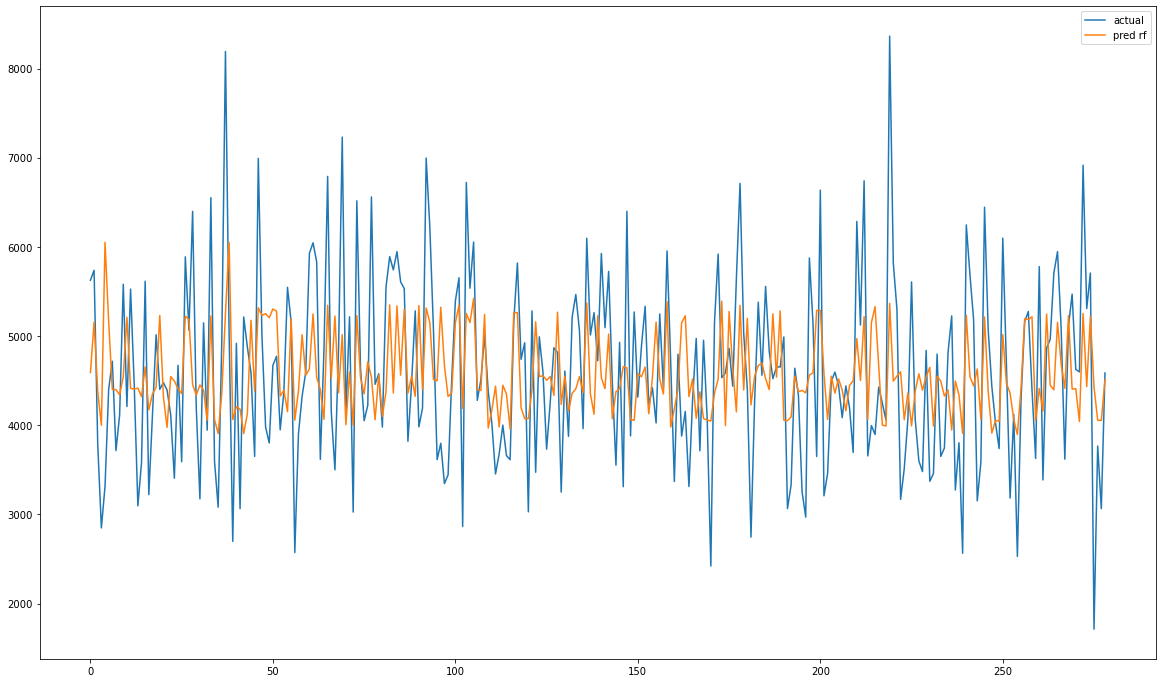

In [164]:
y_pred = model.predict(X_overig_test)
print(model)
print("\tExplained variance:", explained_variance_score(y_overig_test, y_pred))
print('\tMean Absolute Error (MAE):', metrics.mean_absolute_error(y_overig_test, y_pred))
print('\tMean Squared Error (MSE):', metrics.mean_squared_error(y_overig_test, y_pred))
print('\tRoot Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_overig_test, y_pred)))
print('\tMean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_overig_test, y_pred))
print('\tR Squared (R2):', metrics.r2_score(y_overig_test, y_pred))
plt.plot(y_overig_test.reset_index(drop=True), label = 'actual')
plt.plot(y_pred, label = 'pred rf')

plt.legend()

#### Multi-output regressor

In [96]:
# Multi output regression

x_multi_target = df_totaal_events_weather.drop([
                                       'Datum',
                                 'UitbetalingVA',
                          'UitbetalingToeslagen',
                    'Binnengekomen bij Provider',
                     'Doorgeleid naar keuzemenu',
                'Door beller opgehangen in menu',
                 'Automatisch behandeld in menu',
                    ('Doorverbindingen', 'AUTO'),
              ('Doorverbindingen', 'BUITENLAND'),
                  ('Doorverbindingen', 'DOUANE'),
           ('Doorverbindingen', 'INTERMEDIAIRS'),
           ('Doorverbindingen', 'ONDERNEMINGEN'),
               ('Doorverbindingen', 'ONTBREEKT'),
                  ('Doorverbindingen', 'OVERIG'),
           ('Doorverbindingen', 'PARTICULIEREN'),
               ('Doorverbindingen', 'TOESLAGEN'),
                  ('Doorverbindingen', 'TOTAAL'),
                            ('Wachtrij', 'AUTO'),
                      ('Wachtrij', 'BUITENLAND'),
                   ('Wachtrij', 'INTERMEDIAIRS'),
                   ('Wachtrij', 'ONDERNEMINGEN'),
                       ('Wachtrij', 'ONTBREEKT'),
                          ('Wachtrij', 'OVERIG'),
                   ('Wachtrij', 'PARTICULIEREN'),
                       ('Wachtrij', 'TOESLAGEN'),
                          ('Wachtrij', 'TOTAAL'),
                 ('Wachtrij_opgehangen', 'AUTO'),
           ('Wachtrij_opgehangen', 'BUITENLAND'),
        ('Wachtrij_opgehangen', 'INTERMEDIAIRS'),
        ('Wachtrij_opgehangen', 'ONDERNEMINGEN'),
            ('Wachtrij_opgehangen', 'ONTBREEKT'),
               ('Wachtrij_opgehangen', 'OVERIG'),
        ('Wachtrij_opgehangen', 'PARTICULIEREN'),
            ('Wachtrij_opgehangen', 'TOESLAGEN'),
               ('Wachtrij_opgehangen', 'TOTAAL'),
                            ('Geholpen', 'AUTO'),
                      ('Geholpen', 'BUITENLAND'),
                   ('Geholpen', 'INTERMEDIAIRS'),
                   ('Geholpen', 'ONDERNEMINGEN'),
                       ('Geholpen', 'ONTBREEKT'),
                          ('Geholpen', 'OVERIG'),
                   ('Geholpen', 'PARTICULIEREN'),
                       ('Geholpen', 'TOESLAGEN'),
                          ('Geholpen', 'TOTAAL'),
                ('Gemiddelde_wachttijd', 'AUTO'),
          ('Gemiddelde_wachttijd', 'BUITENLAND'),
       ('Gemiddelde_wachttijd', 'INTERMEDIAIRS'),
       ('Gemiddelde_wachttijd', 'ONDERNEMINGEN'),
           ('Gemiddelde_wachttijd', 'ONTBREEKT'),
              ('Gemiddelde_wachttijd', 'OVERIG'),
       ('Gemiddelde_wachttijd', 'PARTICULIEREN'),
           ('Gemiddelde_wachttijd', 'TOESLAGEN'),
              ('Gemiddelde_wachttijd', 'TOTAAL'),
               #                          'Maand',
                                          'Jaar',
                 'ComplexityScore_ondernemingen',
                 'ComplexityScore_particulieren',
                    'ComplexityScore_buitenland',
                        'ComplexityScore_overig',
                 'ComplexityScore_intermediairs',
                     'ComplexityScore_toeslagen',
                          'ComplexityScore_auto',
               #                     'Prinsjesdag',
               #                  'Schoolvakantie',
               #               'WerkdagNaFeestdag',
               #           'DeadlineOmzetbelasting',
               #       'DeadlineInkomstenbelasting',
               #            'DeadlineLoonbelasting',
               #  'DeadlineVennootschapsbelasting',
               #   'IncassoMotorrijtuigenbelasting',
               #                       'min_temp',
               #                       'max_temp',
               #                        'zonuren',
               #                      'regenduur',
          ], axis = 1)
y_multi_target = df_totaal_events_weather[[('Doorverbindingen', 'OVERIG'), ('Doorverbindingen', 'BUITENLAND'),
                                          ('Doorverbindingen', 'AUTO'),
                                          ('Doorverbindingen', 'INTERMEDIAIRS'), ('Doorverbindingen', 'ONDERNEMINGEN'),
                                          ('Doorverbindingen', 'PARTICULIEREN'), ('Doorverbindingen', 'TOESLAGEN')]]

from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(x_multi_target, y_multi_target, test_size=0.20, random_state=33)
# Create the SVR regressor
regressor_multi = GradientBoostingRegressor(n_estimators = 200, max_depth = 3, random_state = 42)

# Create the Multioutput Regressor
mor = MultiOutputRegressor(regressor_multi)

# Train the regressor
mor = mor.fit(X_train, y_train)

# Generate predictions for testing data
y_pred = mor.predict(X_test)

# Evaluate the regressor
rmse_one = np.sqrt(mean_squared_error(y_test[[('Doorverbindingen', 'OVERIG')]], y_pred[:,0]))
rmse_two = np.sqrt(mean_squared_error(y_test[('Doorverbindingen', 'BUITENLAND')], y_pred[:,1]))
rmse_three = np.sqrt(mean_squared_error(y_test[('Doorverbindingen', 'AUTO')], y_pred[:,2]))
rmse_four = np.sqrt(mean_squared_error(y_test[('Doorverbindingen', 'INTERMEDIAIRS')], y_pred[:,3]))
rmse_five = np.sqrt(mean_squared_error(y_test[('Doorverbindingen', 'ONDERNEMINGEN')], y_pred[:,4]))
rmse_six = np.sqrt(mean_squared_error(y_test[('Doorverbindingen', 'PARTICULIEREN')], y_pred[:,5]))
rmse_seven = np.sqrt(mean_squared_error(y_test[('Doorverbindingen', 'TOESLAGEN')], y_pred[:,6]))

print(f'RMSE for OVERIGE regressor: {rmse_one}')
print(f'RMSE for BUITENLAND regressor: {rmse_two}')
print(f'RMSE for AUTO regressor: {rmse_three}')
print(f'RMSE for INTERMEDIAIRS regressor: {rmse_four}')
print(f'RMSE for ONDERNEMINGEN regressor: {rmse_five}')
print(f'RMSE for PARTICULIEREN regressor: {rmse_six}')
print(f'RMSE for TOESLAGEN regressor: {rmse_seven}')
print('RMSE overall regressor:', np.sqrt(mean_squared_error(y_test, y_pred)))

mae_one = mean_absolute_error(y_test[[('Doorverbindingen', 'OVERIG')]], y_pred[:,0])
mae_two = mean_absolute_error(y_test[('Doorverbindingen', 'BUITENLAND')], y_pred[:,1])
mae_three = mean_absolute_error(y_test[('Doorverbindingen', 'AUTO')], y_pred[:,2])
mae_four = mean_absolute_error(y_test[('Doorverbindingen', 'INTERMEDIAIRS')], y_pred[:,3])
mae_five = mean_absolute_error(y_test[('Doorverbindingen', 'ONDERNEMINGEN')], y_pred[:,4])
mae_six = mean_absolute_error(y_test[('Doorverbindingen', 'PARTICULIEREN')], y_pred[:,5])
mae_seven = mean_absolute_error(y_test[('Doorverbindingen', 'TOESLAGEN')], y_pred[:,6])

print(f'\nMAE for OVERIGE regressor: {mae_one}') 
print(f'MAE for BUITENLAND regressor: {mae_two}')
print(f'MAE for AUTO regressor: {mae_three}')
print(f'MAE for INTERMEDIAIRS regressor: {mae_four}')
print(f'MAE for ONDERNEMINGEN regressor: {mae_five}')
print(f'MAE for PARTICULIEREN regressor: {mae_six}')
print(f'MAE for TOESLAGEN regressor: {mae_seven}')
print('MAE overall regressor:', mean_absolute_error(y_test, y_pred))

print('\n\nR Squared (R2) OVERIG regressor:', metrics.r2_score(y_test[[('Doorverbindingen', 'OVERIG')]], y_pred[:,0]))
print('R Squared (R2) BUITENLAND regressor:', metrics.r2_score(y_test[[('Doorverbindingen', 'BUITENLAND')]], y_pred[:,1]))
print('R Squared (R2) AUTO regressor:', metrics.r2_score(y_test[[('Doorverbindingen', 'AUTO')]], y_pred[:,2]))
print('R Squared (R2) INTERMEDIAIRS regressor:', metrics.r2_score(y_test[[('Doorverbindingen', 'INTERMEDIAIRS')]], y_pred[:,3]))
print('R Squared (R2) ONDERNEMINGEN regressor:', metrics.r2_score(y_test[[('Doorverbindingen', 'ONDERNEMINGEN')]], y_pred[:,4]))
print('R Squared (R2) PARTICULIEREN regressor:', metrics.r2_score(y_test[[('Doorverbindingen', 'PARTICULIEREN')]], y_pred[:,5]))
print('R Squared (R2) TOESLAGEN regressor:', metrics.r2_score(y_test[[('Doorverbindingen', 'TOESLAGEN')]], y_pred[:,6]))
print('R Squared (R2) overall regressor:', metrics.r2_score(y_test, y_pred))


RMSE for OVERIGE regressor: 894.1015058755225
RMSE for BUITENLAND regressor: 425.68180344489184
RMSE for AUTO regressor: 497.92393395961795
RMSE for INTERMEDIAIRS regressor: 428.15995465482894
RMSE for ONDERNEMINGEN regressor: 1767.2095930576018
RMSE for PARTICULIEREN regressor: 2356.289869973715
RMSE for TOESLAGEN regressor: 3828.9182017045396
RMSE overall regressor: 1880.2590240956813

MAE for OVERIGE regressor: 720.4687475057075
MAE for BUITENLAND regressor: 349.74313513327536
MAE for AUTO regressor: 389.7719174399978
MAE for INTERMEDIAIRS regressor: 310.38545255898623
MAE for ONDERNEMINGEN regressor: 1238.7892014025808
MAE for PARTICULIEREN regressor: 1734.064981519286
MAE for TOESLAGEN regressor: 2113.664268198069
MAE overall regressor: 979.5553862511289


R Squared (R2) OVERIG regressor: 0.1838064717610497
R Squared (R2) BUITENLAND regressor: 0.4251747303067819
R Squared (R2) AUTO regressor: 0.58851115362544
R Squared (R2) INTERMEDIAIRS regressor: 0.7243962911549549
R Squared (R2